# Ideas 
This notebook is as an ideas HQ for the GDL project

### Imports

In [1]:
import os

wd = '/Users/riccardoconci/Local_documents/ACS submissions/GeomDL/'
os.chdir(wd)

In [2]:


from TGB.tgb.utils.info import DATA_URL_DICT
from TGB.tgb.linkproppred.dataset import LinkPropPredDataset

import requests
import zipfile
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import itertools
from itertools import combinations
import pandas as pd
from scipy.stats import wasserstein_distance
from scipy.special import rel_entr

import pickle
import random




In [3]:
#name = "tgbl-wiki" 
#name = 'tgbl-review'
name = 'tgbl-coin'
#name = 'tgbl-comment'
#name = 'tgbl-flight'

dataset = LinkPropPredDataset(name=name, root="datasets", preprocess=True)
train_mask = dataset.train_mask
val_mask = dataset.val_mask
test_mask = dataset.test_mask

/Users/riccardoconci/Local_documents/ACS submissions/GeomDL/TGB/tgb/datasets/tgbl_coin/tgbl-coin_edgelist.csv
raw file found, skipping download
Dataset directory is  /Users/riccardoconci/Local_documents/ACS submissions/GeomDL/TGB/tgb/datasets/tgbl_coin
OUT_DF /Users/riccardoconci/Local_documents/ACS submissions/GeomDL/TGB/tgb/datasets/tgbl_coin/ml_tgbl-coin.pkl
OUT_EDGE_FEAT /Users/riccardoconci/Local_documents/ACS submissions/GeomDL/TGB/tgb/datasets/tgbl_coin/ml_tgbl-coin_edge.pkl
loading processed file


In [12]:
dataset.full_data['edge_feat'].shape

(67169570, 16)

In [100]:
data = dataset.full_data  #a dictioinary stores all the edge data
data_df = pd.DataFrame([data['sources'], data['destinations'], data['timestamps']]).T
data_df.columns = ['Source', 'Destination', 'Timestamp']



# Split the DataFrame into training, validation, and test sets



raw file found, skipping download
Dataset directory is  /Users/riccardoconci/Local_documents/ACS submissions/GeomDL/TGB/tgb/datasets/tgbl_coin
loading processed file


In [101]:
import pickle
with open( name + '_data_df.pkl', 'wb') as file: 
    # A new file will be created 
    pickle.dump(data_df, file) 




In [7]:
file_name = name + '_data_df.pkl'

with open(file_name, 'rb') as file:
    data_df = pickle.load(file)

In [8]:
data_df['train_mask'] = dataset.train_mask
data_df['val_mask'] = dataset.val_mask
data_df['test_mask'] = dataset.test_mask

data_df

,Source,Destination,Timestamp,train_mask,val_mask,test_mask
0,0.0,1.0,1.546319e+09,True,False,False
1,0.0,2.0,1.546319e+09,True,False,False
2,3.0,4.0,1.546319e+09,True,False,False
3,5.0,5.0,1.546319e+09,True,False,False
4,3.0,1.0,1.546319e+09,True,False,False
...,...,...,...,...,...,...
67169565,305.0,2228.0,1.667189e+09,False,False,True
67169566,6749.0,1063.0,1.667189e+09,False,False,True
67169567,1609.0,78.0,1.667189e+09,False,False,True
67169568,85.0,330.0,1.667189e+09,False,False,True


In [235]:
data_df['AdjustedTimeStamp'] = data_df['Timestamp'] - data_df['Timestamp'].min()
data_df['DateTime'] = pd.to_datetime(data_df['Timestamp'], unit='s')
data_df

,Source,Destination,Timestamp,train_mask,val_mask,test_mask,AdjustedTimeStamp,DateTime
0,0.0,1.0,1.546319e+09,True,False,False,0.0,2019-01-01 05:00:00
1,0.0,2.0,1.546319e+09,True,False,False,0.0,2019-01-01 05:00:00
2,3.0,4.0,1.546319e+09,True,False,False,0.0,2019-01-01 05:00:00
3,5.0,5.0,1.546319e+09,True,False,False,0.0,2019-01-01 05:00:00
4,3.0,1.0,1.546319e+09,True,False,False,0.0,2019-01-01 05:00:00
...,...,...,...,...,...,...,...,...
67169565,305.0,2228.0,1.667189e+09,False,False,True,120870000.0,2022-10-31 04:00:00
67169566,6749.0,1063.0,1.667189e+09,False,False,True,120870000.0,2022-10-31 04:00:00
67169567,1609.0,78.0,1.667189e+09,False,False,True,120870000.0,2022-10-31 04:00:00
67169568,85.0,330.0,1.667189e+09,False,False,True,120870000.0,2022-10-31 04:00:00


### Measuring recurrency: ideas & key metrics





1) Find the distribution of time_diffs in the dataset 

In [236]:
data_df.sort_values(by=['Source', 'Destination', 'AdjustedTimeStamp'], inplace=True)
data_df['TimeDiff'] = data_df.groupby(['Source', 'Destination'])['AdjustedTimeStamp'].diff()

#aggregated = data_df.groupby(['Source', 'Destination'])['TimeDiff'].agg(['min', 'max', 'mean', 'median', 'count']).reset_index().dropna()
data_df['cumulative_count'] = data_df.groupby(['Source', 'Destination']).cumcount() + 1
data_df['count'] = data_df.groupby(['Source', 'Destination'])['Source'].transform('count')


In [237]:
val_df = data_df[data_df['val_mask']==True]
val_threshold = val_df['Timestamp'].min()

In [238]:
#select only the node-node interactions with at least 4 interactions
subset_df = data_df[data_df['count'] >= 4]

#select the node-node interactions where time_diff is not 0
subset_df = subset_df[subset_df['TimeDiff'] != 0].dropna()




In [240]:
subset_df

,Source,Destination,Timestamp,train_mask,val_mask,test_mask,AdjustedTimeStamp,DateTime,TimeDiff,cumulative_count,count
38158,0.0,0.0,1.546405e+09,True,False,False,86400.0,2019-01-02 05:00:00,86400.0,3,1960
69790,0.0,0.0,1.546492e+09,True,False,False,172800.0,2019-01-03 05:00:00,86400.0,4,1960
102474,0.0,0.0,1.546578e+09,True,False,False,259200.0,2019-01-04 05:00:00,86400.0,5,1960
150628,0.0,0.0,1.546664e+09,True,False,False,345600.0,2019-01-05 05:00:00,86400.0,9,1960
179346,0.0,0.0,1.546751e+09,True,False,False,432000.0,2019-01-06 05:00:00,86400.0,11,1960
...,...,...,...,...,...,...,...,...,...,...,...
66626916,18083.0,1015.0,1.666411e+09,False,False,True,120092400.0,2022-10-22 04:00:00,345600.0,3,4
66819740,18083.0,1015.0,1.666670e+09,False,False,True,120351600.0,2022-10-25 04:00:00,259200.0,4,4
66852317,18084.0,16500.0,1.666757e+09,False,False,True,120438000.0,2022-10-26 04:00:00,1036800.0,2,4
66917465,18084.0,16500.0,1.666843e+09,False,False,True,120524400.0,2022-10-27 04:00:00,86400.0,3,4


In [241]:

# count the number of time differences 
time_diff_count_df = subset_df.groupby('TimeDiff').size().reset_index(name='time_diff_count')

#and sort the time differences by the count 
time_diff_count_df.sort_values('time_diff_count', inplace=True, ascending=False)

time_diff_count_df['cumulative_count'] = time_diff_count_df['time_diff_count'].cumsum()
total_count = time_diff_count_df['time_diff_count'].sum()

#time_diff_count_df = time_diff_count_df[time_diff_count_df['time_diff_count'] >= 4]



time_diff_count_df

,TimeDiff,time_diff_count,cumulative_count
1,86400.0,13532934,13532934
4,172800.0,3113051,16645985
7,259200.0,1825974,18471959
10,345600.0,1265075,19737034
13,432000.0,833568,20570602
...,...,...,...
3579,108777600.0,1,29470424
3559,107913600.0,1,29470425
3558,107910000.0,1,29470426
3502,105408000.0,1,29470427


In [242]:
with open( name + '_time_diff_count_df.pkl', 'wb') as file: 
    # A new file will be created 
    pickle.dump(time_diff_count_df, file) 


In [5]:
base = 'Pickle_files/'
file_name = base + name + '_time_diff_count_df.pkl'

with open(file_name, 'rb') as file:
    time_diff_count_df = pickle.load(file)

In [6]:
len(time_diff_count_df)

2199710

In [244]:
sum(time_diff_count_df['time_diff_count'])

29470428

### Sampling the recurrency checks

Now that we have ranked the interactios by time diffs and selected the 90% that accounts for all the edges, it would be great to not have to check for every single time diff, especially if they are close together it means that a 10% noise will actually be doubling the work...

1) truncate 
- basically NOT take all the time diffs for 90% of data (or with at least 4 consecutive events), but rather just sample to the top 100 time diffs and then see how much data is actually being accounted for 

2) random sampling weighted by probability distribution  
- in this method we sample randomly based on the distribution of time diffs, then take the unique set.. the benefit is that we get a decent variation in time diffs to check, not just the most common, but the downside is that it's very unstructured and will likely give different results each time...  

3) clustering
- The third and most complex is to cluster the time diffs to check based on which ones are taken into account by the noise variation.. For example in a sequence of 8, 9, 10, 11, 12 saying that each number has a halo around it of 10% its value and that if any number is within that 10% it should be removed, will give 8, 10, 12. BUT major issues occur when these numbers become consecutive and then they all start to overlap, for example 10, 11, 12, 13, 14, 15, 16, 17 ... each time, the numbers check their neighbours and delete them sequentially leading to a final output of 10, 17 which leaves a big gap in the middle... I have attempted to fix this but it is genuinely difficult... (effectively we want to take a sequence and make sure that the whole sequence space is covered by the smallest number of units possible, each unit with a varying influence size ). My impression is that this is likely not possible analytically/simple algorithmically without having some sort of approximation algorithm like elastic net that gradually comes to a chosen configuration 


4) Recurrent vs random distributions
- a fourth way could be to apply a distance between the time diffs in a random distribution vs a periodic distribution, then pick the source-destination nodes that are 



5) Brute Force:
- without these we could always give up any computational efficiency and run every single time diff... this is horrendously expensive especially on the longer datasets but would give the more correct answer of what % of interactions show recurrency of any type.





In [12]:
import numpy as np

def clever_sampler(time_diff_count_df, noise_value, final_length):
    # Sort time_diff_count_df by 'time_diff_count' to get the top 10 most common time diffs
    top_common_time_diffs = time_diff_count_df.sort_values(by='time_diff_count', ascending=False).head(10)['TimeDiff'].tolist()
    
    # Initialize 'explored' with the top 10 most common time diffs
    explored = top_common_time_diffs.copy()

    # Generate the initial 'forbidden' ranges based on these top common time diffs
    forbidden = [(val - (noise_value/100)*val, val + (noise_value/100)*val) for val in explored]

    sequence = time_diff_count_df['TimeDiff'].sort_values(ascending=True).tolist()
    attempts = 0
    max_attempts = 1000
    total_count = time_diff_count_df['time_diff_count'].sum()

    while len(explored) < final_length and attempts < max_attempts:
        r = np.random.choice(time_diff_count_df['TimeDiff'], p=time_diff_count_df['time_diff_count']/total_count)
        #print('checking samples')
        if all([r < lower or r > upper for lower, upper in forbidden]):
            #print('Found a sample!')
            explored.append(r)
            upper = r + (noise_value/100)*r
            lower = r - (noise_value/100)*r
            selected_values = [x for x in sequence if lower <= x <= upper]
            
            for val in selected_values:
                if (val - (noise_value/100)*val, val + (noise_value/100)*val) not in forbidden:
                    forbidden.append((val - (noise_value/100)*val, val + (noise_value/100)*val))
        attempts += 1
    return np.sort(explored)


In [13]:

def calculate_edges_checked(sub_list,noise_value, time_diff_count_df ):
    # Calculate the enhanced (±10%) ranges for each value in the first list
    total_count = time_diff_count_df['time_diff_count'].sum()
    noise_frac = noise_value/100
    enhanced_ranges = [(x - noise_frac * x, x + noise_frac * x) for x in sub_list]
    #print(enhanced_ranges)
    # Function to check if a number falls within any range in a list of ranges
    def is_in_any_range(number, ranges):
        return any(lower <= number <= upper for lower, upper in ranges)

    time_diff_seq = time_diff_count_df['TimeDiff']
    # Collect the values in the second list that fall within any of the enhanced ranges
    included_values = [x for x in time_diff_seq if is_in_any_range(x, enhanced_ranges)]

    #print(f"Values from the second list included in the enhanced first list: {included_values}")

    perc_time_diffs = len(included_values)/len(time_diff_seq) * 100
    #print(perc_time_diffs)

    filtered_df = time_diff_count_df[time_diff_count_df['TimeDiff'].isin(included_values)]
    num_edges_checked = filtered_df['time_diff_count'].sum()
    perc_edges = num_edges_checked / total_count*100
    #print(perc_edges)

    return(perc_time_diffs, perc_edges)

In [ ]:
clever_sampler(time_diff_count_df, 10, )

In [15]:
noise_value = 10
sub_list_lists = []
perc_time_diff_list = []
perc_edges_list= []
for i in range(10,30):
    sub_list = clever_sampler(time_diff_count_df, noise_value, i)
    sub_list_lists.append(sub_list)
    perc_time_diff, perc_edges = calculate_edges_checked(sub_list,noise_value, time_diff_count_df )
    perc_time_diff_list.append(perc_time_diff)
    perc_edges_list.append(perc_edges)
    print(len(sub_list), perc_edges)
    


10 8.981733966184134
checking samples
Found a sample!


KeyboardInterrupt: 

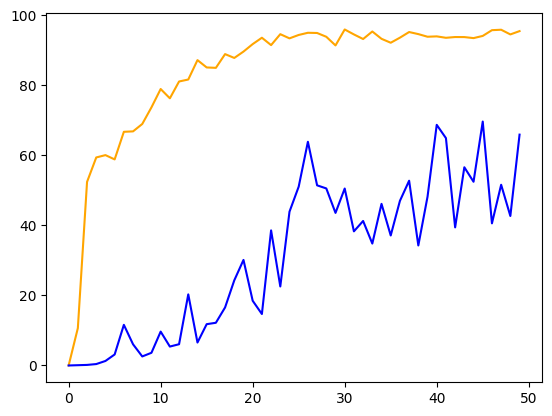

In [144]:
plt.plot(perc_edges_list, color= 'orange')
plt.plot(perc_time_diff_list, color = 'blue')
plt.show()

In [145]:
perc_time_diff_list[21]

14.696399785061795

In [118]:
len(sub_list_lists)

51

In [114]:
print(np.argmax(perc_time_diff_list))
print(np.argmax(perc_edges_list))

print(perc_time_diff_list[12])
print(perc_edges_list[12])

47
50
8.369466884271109
20.81201701466818


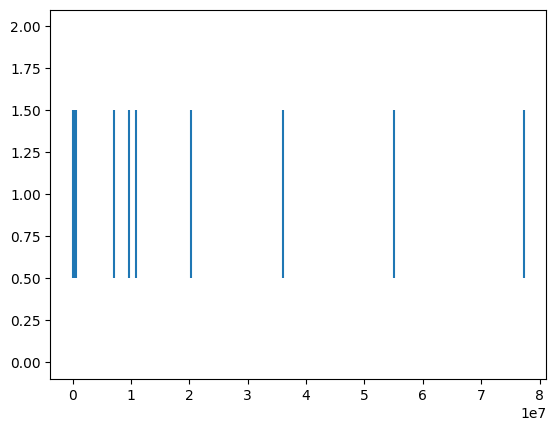

In [62]:
sub_list = sub_list_lists[12]
#sub_list = clever_sampler(time_diff_count_df, noise_value, 50)
plt.eventplot(sub_list)

In [75]:

def plot_sampler_effectiveness(sub_list, time_diff_seq, dataset_name):

    # Calculate the "umbrella" range as +/- 10% for the first list
    enhanced_ranges = [(x - 0.1 * x, x + 0.1 * x) for x in sub_list]

    # Plotting the first list with their umbrellas at y-value=1, horizontally
    plt.figure(figsize=(8, 6))
    y_value_first = np.ones(len(sub_list))
    plt.errorbar(sub_list, y_value_first, xerr=[0.1 * x for x in sub_list], fmt='o', ecolor='orange', elinewidth=3, capsize=0, label='Sampled Time Diffs ±10%', linestyle="None")

    # Plotting the second list as short vertical lines at y-value=0.95, color-coded based on condition
    for x in time_diff_seq:
        # Determine color based on whether the value is within any of the enhanced ranges of the first list
        color = 'green' if is_in_any_range(x, enhanced_ranges) else 'pink'
        plt.vlines(x, 0.925, 0.975, colors=color, linewidths=1.5)  # Use thicker lines for better visibility

    # Customize the plot
    #plt.xticks(sub_list + time_diff_seq, rotation=45)
    plt.yticks([1], ['Sampled Time Diffs'])
    plt.yticks([0], ['Time Diff data'])
    plt.xlabel('Time Diffs')
    plt.title(f'Selected Time Diff values from {dataset_name} dataset using sampling method')
    plt.ylim(0.90, 1.05)  # Adjust y-limits to zoom in on the area of interest
    plt.xticks([])
    plt.legend()
    plt.tight_layout()  # Adjust the layout
    save_title = dataset_name + '_sampled_time_diffs' 
    plt.savefig(save_title + '.jpg')

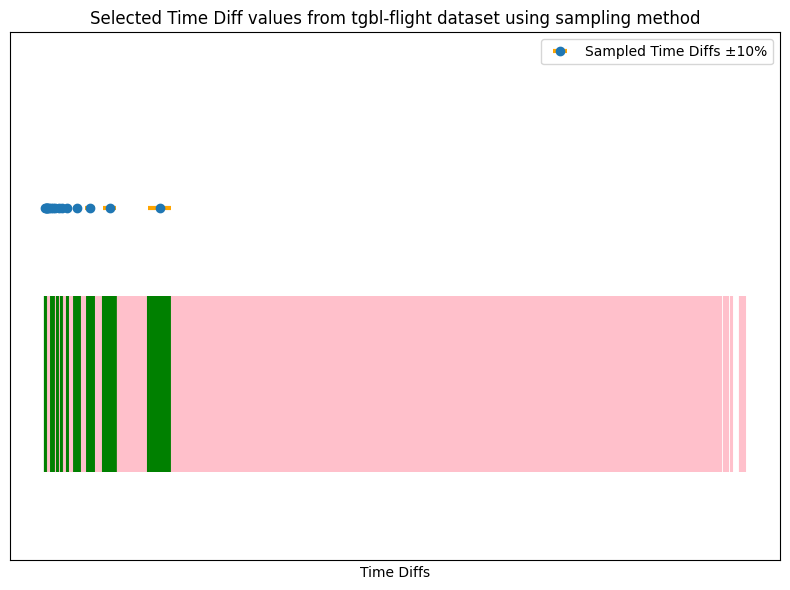

In [76]:
plot_sampler_effectiveness(sub_list, time_diff_seq, name)

In [96]:
import matplotlib.pyplot as plt
import numpy as np

def plot_sampler_effectiveness_opacity(sub_list, time_diff_count, dataset_name):
    # Calculate the "umbrella" range as +/- 10% for the first list
    enhanced_ranges = [(x - 0.1 * x, x + 0.1 * x) for x in sub_list]

    # Determine the range for opacity normalization
    min_count = time_diff_count['time_diff_count'].min()
    max_count = time_diff_count['time_diff_count'].max()

    # Plotting the first list with their umbrellas at y-value=1, horizontally
    plt.figure(figsize=(8, 6))
    y_value_first = np.ones(len(sub_list))
    plt.errorbar(sub_list, y_value_first, xerr=[0.1 * x for x in sub_list], fmt='o', ecolor='orange', elinewidth=3, capsize=0, label='Sampled Time Diffs ±10%', linestyle="None")

    # Plotting the second list as short vertical lines, with normalized opacity based on count
    for x, count in zip(time_diff_count['TimeDiff'], time_diff_count['time_diff_count']):
        # Normalize the opacity between 0 and 1
        normalized_opacity = (count - min_count) / (max_count - min_count)
        color = 'green' if is_in_any_range(x, enhanced_ranges) else 'pink'
        opacity = min(normalized_opacity + 0.2, 1)
        #print(opacity)
        plt.vlines(x, 0.925, 0.975, colors=color, linewidths=0.2, alpha=opacity)  # Ensure some visibility for all lines

    # Customize the plot
    plt.xlabel('Time Diffs')
    plt.title(f'Selected Time Diff values from {dataset_name} dataset using sampling method')
    plt.xlim(-enhanced_ranges[-1][1]/15, enhanced_ranges[-1][1])  # Adjust x-axis limits to focus on the range of interest
    plt.ylim(0.90, 1.05)
    plt.xticks([])
    plt.yticks([1], ['Sampled Time Diffs'])  # Adjust y-ticks
    plt.legend()
    plt.tight_layout()
    save_title = dataset_name + '_sampled_time_diffs_opacity'
    plt.savefig(save_title + '.jpg')
    plt.show()

# Helper function to check if a value falls within any enhanced range
def is_in_any_range(num, ranges):
    return any(lower <= num <= upper for lower, upper in ranges)

# Example usage setup:
# sub_list = [your_sub_list_values]
# time_diff_count = DataFrame with columns ['TimeDiff', 'time


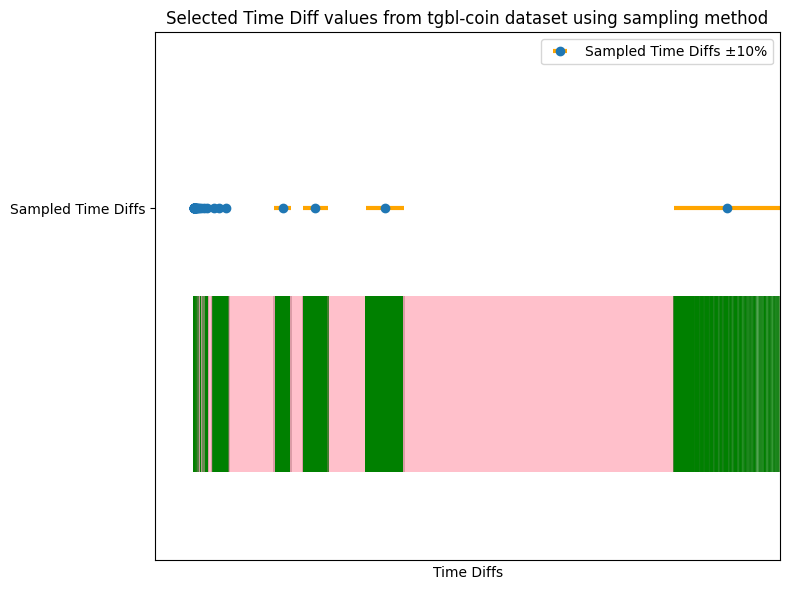

In [97]:
plot_sampler_effectiveness_opacity(sub_list, time_diff_count_df, name)


In [63]:
def plot_sampler_effectiveness_height(sub_list, time_diff_count, dataset_name):
    # Calculate the "umbrella" range as +/- 10% for the first list
    enhanced_ranges = [(x - 0.1 * x, x + 0.1 * x) for x in sub_list]

    # Use the upper bound of the last enhanced range as the x-axis limit
    # Plotting setup remains the same
    plt.figure(figsize=(8, 6))
    y_value_first = np.ones(len(sub_list))
    plt.errorbar(sub_list, y_value_first, xerr=[0.1 * x for x in sub_list], fmt='o', ecolor='orange', elinewidth=3, capsize=0, label='Sampled Time Diffs ±10%', linestyle="None")

    # Normalize time_diff_count for plotting
    max_count = time_diff_count['time_diff_count'].max()
    normalized_heights = 0.9 + (time_diff_count['time_diff_count'] / max_count) * 0.1

    # Plotting time diffs with normalized frequency
    for x, height in zip(time_diff_count['TimeDiff'], normalized_heights):
        color = 'green' if is_in_any_range(x, enhanced_ranges) else 'pink'
        plt.vlines(x, 0.9, height, colors=color, linewidth=1.5)

    # Customize and zoom in on the plot
    plt.xlabel('Time Diffs')
    plt.title(f'Selected Time Diff values from {dataset_name} dataset using sampling method')
    plt.xlim(-enhanced_ranges[-1][1]/15, enhanced_ranges[-1][1])  # Adjust x-axis limits to focus on the range of interest
    plt.ylim(0.88, 1.02)
    plt.xticks([])
    plt.yticks([1], ['Sampled Time Diffs'])  # Adjust y-ticks
    plt.legend()
    plt.tight_layout()
    save_title = dataset_name + '_sampled_time_diffs_zoomed'
    plt.savefig(save_title + '.jpg')
    plt.show()

# Helper function to check if a value falls within any enhanced range
def is_in_any_range(num, ranges):
    return any(lower <= num <= upper for lower, upper in ranges)


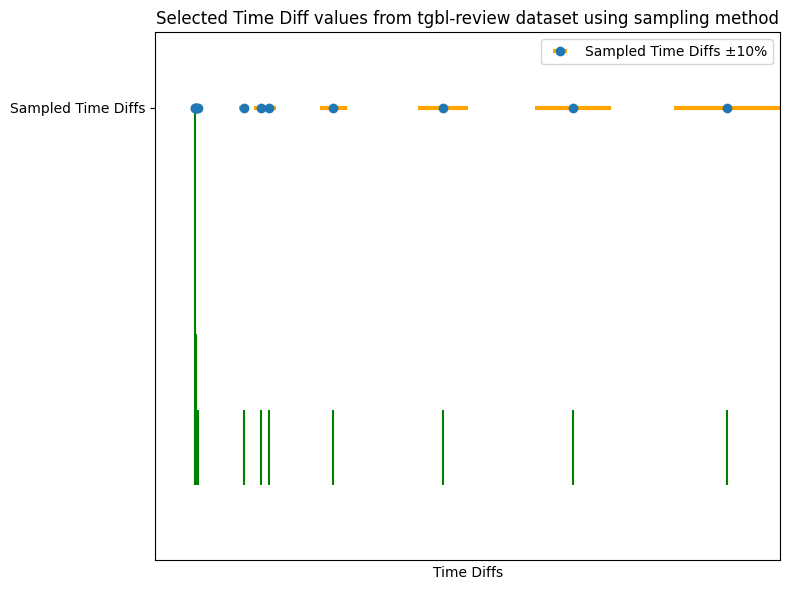

In [64]:
plot_sampler_effectiveness_height(sub_list, time_diff_count_df, name)


In [14]:
import numpy as np
import matplotlib.pyplot as plt

def plot_sampler_effectiveness_height(sub_list, time_diff_count, dataset_name):
    # Calculate the "umbrella" range as +/- 10% for the first list
    enhanced_ranges = [(x - 0.1 * x, x + 0.1 * x) for x in sub_list]

    plt.figure(figsize=(8, 6))

    # Normalize time_diff_count for plotting on a logarithmic scale
    max_count = time_diff_count['time_diff_count'].max()
    normalized_heights = 0.9 + (time_diff_count['time_diff_count'] / max_count) * 0.1

    # Plotting time diffs with normalized frequency
    for x, height in zip(time_diff_count['TimeDiff'], normalized_heights):
        color = 'green' if is_in_any_range(x, enhanced_ranges) else 'pink'
        plt.vlines(x, 0.9, height, colors=color, linewidth=1.5)

    # Now plot the "Sampled Time Diffs ±10%" with adjusted y-axis values
    y_value_adjusted = [height for _, height in zip(sub_list, normalized_heights)]
    plt.errorbar(sub_list, y_value_adjusted, yerr=[0.1 * y for y in y_value_adjusted], fmt='o', ecolor='orange', elinewidth=3, capsize=0, label='Sampled Time Diffs ±10%', linestyle="None")

    # Customize and zoom in on the plot
    plt.xlabel('Time Diffs')
    plt.title(f'Selected Time Diff values from {dataset_name} dataset using sampling method')

    # Set log scale for both axes and specify tick values
    plt.xscale('log')
    plt.yscale('log')

    # Specify tick values (customize these as needed for your data)
    plt.xticks([10**i for i in range(int(np.log10(sub_list.min())), int(np.log10(sub_list.max()))+1)], rotation=45)
    plt.yticks([10**i for i in range(-3, 4)])  # Example y-axis values

    plt.xlim(right=enhanced_ranges[-1][1])  # Adjust x-axis limits to focus on the range of interest
    plt.ylim(bottom=0.01)  # Set a minimum y-limit for better visualization on a log scale

    plt.legend()
    plt.tight_layout()
    save_title = dataset_name + '_sampled_time_diffs_zoomed'
    plt.savefig(save_title + '.jpg')
    plt.show()

# Helper function to check if a value falls within any enhanced range
def is_in_any_range(num, ranges):
    return any(lower <= num <= upper for lower, upper in ranges)


**PREVIOUS Methods**

In [ ]:

# SAMPLE
samples = np.random.choice(time_diff_count['TimeDiff'], size=20, p=time_diff_count['time_diff_count']/total_count, replace=False)
unique_samples = sorted(list(set(samples)))
plt.eventplot(unique_samples)
print(len(unique_samples))

In [12]:
def refine_list(numbers, percent):
    # Start with the first number in the list
    refined = [numbers[0]]
    numbers_to_remove = []

    for i in range(0, len(numbers)):
        print(i)

        if numbers[i] in numbers_to_remove:
            continue 

        current = numbers[i]
        print('current', current)
        if i != 0:
            prev_num = numbers[i -1]
        
            print('prev_num', prev_num)
        if i == len(numbers)-1: 
            next_num = np.inf
            print('next_num', next_num)
        else:
            next_num = numbers[i + 1]
            print('next_num', next_num)
        
        threshold = current * percent / 100
        print('threshold',threshold)


        #
        if i != len(numbers)-1:  #if i is not the last of the sequence
            if abs(current - next_num) > threshold:
                refined.append(next_num)
            elif abs(current - next_num) <= threshold:
                # If the next number is too close, skip the next number
                numbers_to_remove.append(next_num)

        if i != 0:
            if abs(current- prev_num) <= threshold:
                numbers_to_remove.append(prev_num)
        if i  == len(numbers)-1:
            refined.append(current)
        
        print('refined', refined)
        print('numbers_to_remove', numbers_to_remove)
        
    filtered_list = sorted(list(set([num for num in refined if num not in numbers_to_remove])))
    return filtered_list


In [13]:
def adjust_consecutive_sequences(lst):
    # Result list
    adjusted_list = []
    # Temporary list to hold consecutive sequences
    temp_sequence = []
    
    for i, num in enumerate(lst):
        if i == 0 or num == lst[i - 1] + 1:  # Check if current number is consecutive
            temp_sequence.append(num)  # Add to temporary sequence
        else:
            # Process the previous sequence
            if temp_sequence:
                adjusted_list.extend(temp_sequence[::3])  # Take every 3rd element
            temp_sequence = [num]  # Start a new sequence
        
    # Don't forget to process the last sequence
    if temp_sequence:
        adjusted_list.extend(temp_sequence[::3])
    
    # Handling non-consecutive elements
    # This part depends on how you want to handle non-consecutive numbers. 
    # The above logic assumes you want to include non-consecutive as they are, 
    # and only thin out the consecutive ones.
    
    return adjusted_list


In [14]:
def refine_list_adjusted(numbers, percent):
    # Start with the first number in the list
    refined = [numbers[0]]
    ongoing_final = []

    numbers_to_remove = []

    for i in range(0, len(numbers)):
        print(i)

        if numbers[i] in numbers_to_remove:
            continue 

        current = numbers[i]
        print('current', current)
        if i != 0:
            prev_num = numbers[i -1]
            if prev_num in numbers_to_remove:
                prev_num = ongoing_final[-1]
            print('prev_num', prev_num)
        if i == len(numbers)-1: 
            next_num = np.inf
            print('next_num', next_num)
        else:
            next_num = numbers[i + 1]
            print('next_num', next_num)
        
        threshold = current * percent / 100
        print('threshold',threshold)

    
        if i != len(numbers)-1:  #if i is not the last of the sequence
            if abs(current - next_num) > threshold:
                refined.append(next_num)
            elif abs(current - next_num) <= threshold:
                # If the next number is too close, skip the next number
                numbers_to_remove.append(next_num)

        if i != 0: #if i is not the first of the sequence
            if abs(current- prev_num) <= threshold:
                numbers_to_remove.append(prev_num)
            else:
                refined.append(current)
        if i  == len(numbers)-1:
            refined.append(current)
        
        ongoing_final = sorted(list(set([num for num in refined if num not in numbers_to_remove])))

        print('refined', refined)
        print('numbers_to_remove', numbers_to_remove)
        print('ongoing_final', ongoing_final)
        
    filtered_list = sorted(list(set([num for num in refined if num not in numbers_to_remove])))
    return filtered_list


### Finding recurrent sequences 

Having found a way to subsample (or not) which time diffs we're going to be using to discover our recurrent sequences, let's now write up the functions to do this!!

We look at all the source-destination pairs that have 
- at least k consecutive events 
- that occur with a time diff specified
- +/- a specific noise percentage

Also we further split its functionality: 
1) look at all the recurrent edges regardless within that dataframe
2) further subsample into those that start within the training set and continue into the validation set 


In [106]:
def find_sequences_optimized(df, n, noise_percent, k, timestamp_threshold):
    df = df.copy()
    noise_value = n * noise_percent / 100
    df.sort_values(by=['Source', 'Destination', 'Timestamp'], inplace=True)
    
    # Calculate time differences
    df['Time_Diff'] = df.groupby(['Source', 'Destination'])['Timestamp'].diff()
    within_noise = ((df['Time_Diff'] >= n - noise_value) & (df['Time_Diff'] <= n + noise_value)) | df['Time_Diff'].isna()
    
    # Sequence identification
    df['Sequence_Break'] = (~within_noise).cumsum()
    df['Group_ID'] = df.groupby(['Source', 'Destination', 'Sequence_Break']).ngroup()
    
    
    
    if timestamp_threshold != None:
        #
        potential_sequences = df[df['Timestamp'] > timestamp_threshold - n * k]
        # Ensure sequences span the threshold and meet minimum count
        valid_groups = potential_sequences.groupby('Group_ID').filter(
            lambda x: x['Timestamp'].lt(timestamp_threshold).any() and 
                    x['Timestamp'].gt(timestamp_threshold).any() and
                    len(x) >= k
        )['Group_ID'].unique()
    else:
        valid_groups = df.groupby('Group_ID').filter(
            lambda x:len(x) >= k )['Group_ID'].unique()

    #print("Valid Group IDs:", valid_groups)
    df_filtered = df[df['Group_ID'].isin(valid_groups)]
    
    # Aggregate results without N and Noise_Percentage
    results = df_filtered.groupby(['Source', 'Destination', 'Group_ID']).agg(
        Number_of_Events=('Timestamp', 'size'),
        Timestamps=('Timestamp', list)
    ).reset_index()

    # Add N and Noise_Percentage to the results DataFrame
    results['N'] = n
    results['Noise_value'] = noise_value
    
    # Drop the Group_ID column if it's not needed in the final output
    results.drop(columns='Group_ID', inplace=True)
    
    return results


In [107]:
def find_sequences_across_range_with_threshold(df, n_range, noise_percent, k, timestamp_threshold):
    all_results = []

    for n in n_range:
        print(n)
        result_df = find_sequences_optimized(df, n, noise_percent, k, timestamp_threshold)
        if not result_df.empty:
            all_results.append(result_df)
    
    if all_results:
        final_results_df = pd.concat(all_results, ignore_index=True)
    else:
        final_results_df = pd.DataFrame()
    
    return final_results_df



In [108]:
subset_df

,Source,Destination,Timestamp,train_mask,val_mask,test_mask,TimeDiff,cumulative_count,count
2,1.0,8228.0,77.0,True,False,False,41.0,2,285
4,1.0,8228.0,150.0,True,False,False,73.0,3,285
7,1.0,8228.0,217.0,True,False,False,67.0,4,285
11,1.0,8228.0,300.0,True,False,False,83.0,5,285
12,1.0,8228.0,376.0,True,False,False,76.0,6,285
...,...,...,...,...,...,...,...,...,...
155173,8130.0,9084.0,2630535.0,False,False,True,133.0,11,15
155231,8130.0,9084.0,2631303.0,False,False,True,768.0,12,15
155256,8130.0,9084.0,2631782.0,False,False,True,479.0,13,15
155781,8130.0,9084.0,2643281.0,False,False,True,11499.0,14,15


In [109]:
train_subset_df = subset_df[subset_df['train_mask'] == True]
val_subset_df = subset_df[subset_df['val_mask'] == True]
test_subset_df = subset_df[subset_df['test_mask'] == True]
train_val_subset_df = pd.concat([train_subset_df, val_subset_df], axis=0)

In [110]:
time_diff_count.sort_values(['TimeDiff'], ascending=False, inplace=True)
n_range = sub_list
n_range

[289834.4413443981,
 914811.2033615441,
 1620715.174928772,
 1215381.7052550486,
 90566.7989957306,
 629513.4431464004,
 16272.514042759814,
 2153657.548631156,
 44037.68905150464,
 436596.4747286613,
 155931.66953061588,
 352558.5100878132,
 68137.93795168439,
 124292.10460854192,
 195742.106097525,
 21259.27690119359,
 5493.027729569097,
 54962.42149162594,
 3188.413523194786,
 29117.68572659612,
 13036.804828690112,
 8401.737005104873,
 10539.254993349045,
 3946.1780358124847,
 2360.9730970350815,
 35585.25715081391,
 513.0573088862666,
 1167.542067999151,
 1700.5003259068988,
 6801.267565726403,
 33.761555654875465,
 377.0858653388792,
 782.6283294794376,
 227.74004311212104,
 160.31269576088187]

In [112]:
noise_percent = 10  
k = 4 
timestamp_threshold = val_df['Timestamp'].min()
timestamp_threshold

1862653.0

In [113]:

# Assuming df is your DataFrame loaded with 'Source', 'Destination', and 'Timestamp' columns properly set
final_df = find_sequences_across_range_with_threshold(train_val_subset_df, n_range, noise_percent, k, timestamp_threshold)
final_df

289834.4413443981
914811.2033615441
1620715.174928772
1215381.7052550486
90566.7989957306
629513.4431464004
16272.514042759814
2153657.548631156
44037.68905150464
436596.4747286613
155931.66953061588
352558.5100878132
68137.93795168439
124292.10460854192
195742.106097525
21259.27690119359
5493.027729569097
54962.42149162594
3188.413523194786
29117.68572659612
13036.804828690112
8401.737005104873
10539.254993349045
3946.1780358124847
2360.9730970350815
35585.25715081391
513.0573088862666
1167.542067999151
1700.5003259068988
6801.267565726403
33.761555654875465
377.0858653388792
782.6283294794376
227.74004311212104
160.31269576088187


,Source,Destination,Number_of_Events,Timestamps,N,Noise_value
0,1722.0,8802.0,4,"[1802853.0, 1893419.0, 1976941.0, 2069629.0]",90566.798996,9056.6799


In [114]:
final_df

,Source,Destination,Number_of_Events,Timestamps,N,Noise_value
0,1722.0,8802.0,4,"[1802853.0, 1893419.0, 1976941.0, 2069629.0]",90566.798996,9056.6799


In [115]:
#% of edges in test set that are recurrent
len(final_df) / len(test_subset_df)* 100

# in FLIGHT: 4.197 % of edges in the test set are recurrent 

0.005545696539485359

In [116]:
# of source-destination pairs that show recurrency in the test set 
len(final_df.groupby(['Source', 'Destination'])) / len(test_subset_df.groupby(['Source', 'Destination'])) * 100

#in FLIGHT: 14.53% of source-destination nodes in test set have recurrency 



0.0758150113722517

In [232]:
import pickle
with open( name + '_testset_recurrency_df.pkl', 'wb') as file: 
    # A new file will be created 
    pickle.dump(final_df, file) 

/var/folders/53/d8br5nln6vq67q925j2wx6kc0000gn/T/ipykernel_40781/2073588270.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df['Source_Destination'] = results_df['Source'].astype(str) + "-" + results_df['Destination'].astype(str)


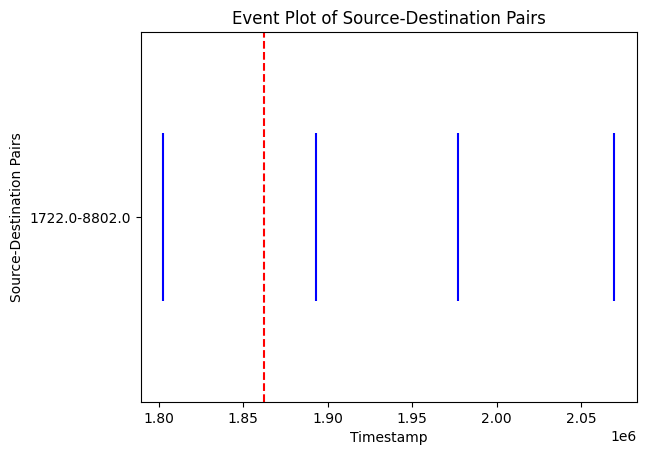

In [120]:
#median_context_window_32 = my_dict['32'][0][1].total_seconds()
#validation_timestamp = val_df['Timestamp'].min()

# Assuming `results_df` is your DataFrame containing the event data
results_df = final_df[:100]
# Generate a unique identifier for each source-destination pair for plotting
results_df['Source_Destination'] = results_df['Source'].astype(str) + "-" + results_df['Destination'].astype(str)
unique_pairs = results_df['Source_Destination'].unique()
pair_mapping = {pair: i for i, pair in enumerate(unique_pairs)}

# Prepare data for event plot
events = []
for _, row in results_df.iterrows():
    pair_index = pair_mapping[row['Source_Destination']]
    timestamps = row['Timestamps']
    events.append((pair_index, timestamps))

# Plot
fig, ax = plt.subplots()
for pair_index, timestamps in events:
    ax.eventplot(timestamps, lineoffsets=pair_index, linelengths=0.8, color='blue')

# Set the y-axis labels to the source-destination pairs
ax.set_yticks(list(pair_mapping.values()))
ax.set_yticklabels(list(pair_mapping.keys()))

ax.set_xlabel('Timestamp')
ax.set_ylabel('Source-Destination Pairs')
ax.set_title('Event Plot of Source-Destination Pairs')

# Add a vertical line at the specified timestamp value
#threshold_timestamp = 1862653.0

ax.axvline(x=timestamp_threshold, color='red', linestyle='--', label=f'Threshold: {timestamp_threshold}')

#ax.axvline(x=validation_timestamp- median_context_window_32, color='Green', linestyle='--', label=f'Context_window')

#ax.legend()
plt.show()


<Axes: >

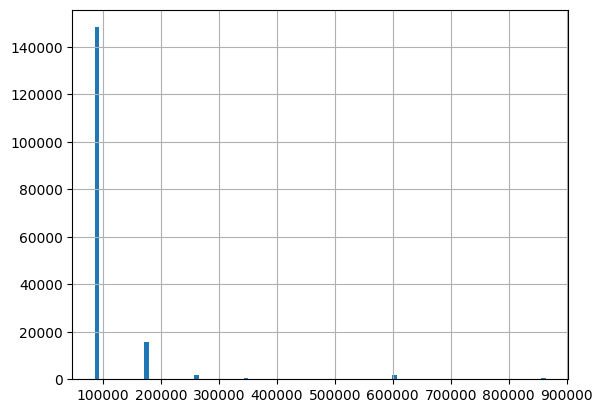

In [237]:
final_df['N'].hist(bins=100)

<Axes: >

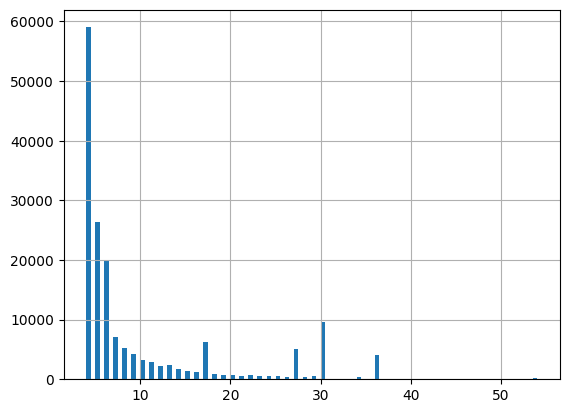

In [238]:
final_df['Number_of_Events'].hist(bins=100)

## Final iterating through datasets

We've now created our tables and saved them... let's go through them and write down the % of recurrency for each and plot some 

In [8]:
def create_subset_df(data_df):
    data_df.sort_values(by=['Source', 'Destination', 'Timestamp'], inplace=True)
    data_df['TimeDiff'] = data_df.groupby(['Source', 'Destination'])['Timestamp'].diff()

    #aggregated = data_df.groupby(['Source', 'Destination'])['TimeDiff'].agg(['min', 'max', 'mean', 'median', 'count']).reset_index().dropna()
    data_df['cumulative_count'] = data_df.groupby(['Source', 'Destination']).cumcount() + 1
    data_df['count'] = data_df.groupby(['Source', 'Destination'])['Source'].transform('count')

    subset_df = data_df[data_df['count'] >= 4]
    subset_df = subset_df[subset_df['TimeDiff'] != 0].dropna()

    time_diff_count = subset_df.groupby('TimeDiff').size().reset_index(name='time_diff_count')
    time_diff_count.sort_values('time_diff_count', inplace=True, ascending=False)
    time_diff_count['cumulative_count'] = time_diff_count['time_diff_count'].cumsum()
    total_count = time_diff_count['time_diff_count'].sum()
    target_count = 0.9 * total_count
    nine_perc_time_diff_df = time_diff_count[time_diff_count['cumulative_count'] <= target_count]
    nine_perc_time_diff_df = nine_perc_time_diff_df[nine_perc_time_diff_df['time_diff_count'] >=4]
    nine_perc_time_diff_df = nine_perc_time_diff_df.head(10) #take the top 10 most common time diffs

    total_edges_checked_for_rec = nine_perc_time_diff_df['cumulative_count'].max()
    perc_edges_checked = total_edges_checked_for_rec / total_count *100
    print(f'The total % of edges checked for recurrency is {perc_edges_checked}')
    
    train_subset_df = subset_df[subset_df['train_mask'] == True]
    val_subset_df = subset_df[subset_df['val_mask'] == True]
    test_subset_df = subset_df[subset_df['test_mask'] == True]

    validation_timestamp = data_df[data_df['val_mask']==True]['Timestamp'].min()

    return subset_df, train_subset_df, val_subset_df, test_subset_df, perc_edges_checked, validation_timestamp

In [9]:
def create_base_df(dataset_name):
    dataset = LinkPropPredDataset(name=dataset_name, root="datasets", preprocess=True)
    train_mask = dataset.train_mask
    val_mask = dataset.val_mask
    test_mask = dataset.test_mask

    # Assuming 'dataset_df' is your DataFrame and 'dataset' contains your masks
    data_df['train_mask'] = dataset.train_mask
    data_df['val_mask'] = dataset.val_mask
    data_df['test_mask'] = dataset.test_mask

    return(data_df)


In [251]:
plot_recurrent_samples(mock_df, 'wiki', 'all', None)

KeyError: 'Timestamps'

In [250]:

def plot_recurrent_samples(final_df, dataset_name, subset_name, validation_timestamp ):

    results_df = final_df.copy()
    if len(final_df)> 200:
        subset = random.sample(range(len(final_df) ), 200)
        results_df = results_df.iloc[subset]
        

    # Generate a unique identifier for each source-destination pair for plotting
    results_df['Source_Destination'] = results_df['Source'].astype(str) + "-" + results_df['Destination'].astype(str)
    unique_pairs = results_df['Source_Destination'].unique()
    pair_mapping = {pair: i for i, pair in enumerate(unique_pairs)}

    # Prepare data for event plot
    events = []
    for _, row in results_df.iterrows():
        pair_index = pair_mapping[row['Source_Destination']]
        timestamps = row['Timestamps']
        events.append((pair_index, timestamps))

    # Plot
    fig, ax = plt.subplots()
    for pair_index, timestamps in events:
        ax.eventplot(timestamps, lineoffsets=pair_index, linelengths=0.8, color='blue')

    # Set the y-axis labels to the source-destination pairs
    ax.set_yticks(list(pair_mapping.values()))
    ax.set_yticklabels(list(pair_mapping.keys()))

    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Source-Destination Pairs')
    ax.set_title('Event Plot of Source-Destination Pairs')

    # Add a vertical line at the specified timestamp value
    if subset_name == '_train_val':
        ax.axvline(x=validation_timestamp, color='Green', linestyle='--', label=f'Threshold: {validation_timestamp}')
    #ax.axvline(x=validation_timestamp- median_context_window_32, color='Green', linestyle='--', label=f'Context_window')

    ax.legend()
    save_title = dataset_name + '_recurrent_SD' + subset_name
    plt.savefig(save_title + '.jpg')


raw file found, skipping download
Dataset directory is  /Users/riccardoconci/Local_documents/ACS submissions/GeomDL/TGB/tgb/datasets/tgbl_wiki
loading processed file
The total % of edges checked for recurrency is 4.2006555806678545


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In tgbl-wiki_train, 0.07300680681110562 % of edges are recurrent. 
In tgbl-wiki_train, 0.9916492693110648 % of source-destination nodes show recurrency. 
In tgbl-wiki_train_val, 0.13136768354984674 % of edges are recurrent. 
In tgbl-wiki_train_val, 0.41884816753926707 % of source-destination nodes show recurrency. 


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In tgbl-wiki_test, 0.15054950569578962 % of edges are recurrent. 
In tgbl-wiki_test, 0.5555555555555556 % of source-destination nodes show recurrency. 
raw file found, skipping download
Dataset directory is  /Users/riccardoconci/Local_documents/ACS submissions/GeomDL/TGB/tgb/datasets/tgbl_review
loading processed file
The total % of edges checked for recurrency is 23.608445297504797
raw file found, skipping download
Dataset directory is  /Users/riccardoconci/Local_documents/ACS submissions/GeomDL/TGB/tgb/datasets/tgbl_coin
loading processed file
The total % of edges checked for recurrency is 3.3717787735222258
In tgbl-coin_train, 0.02879475833889096 % of edges are recurrent. 


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In tgbl-coin_train, 0.1191238077914069 % of source-destination nodes show recurrency. 
In tgbl-coin_train_val, 0.07528894601063582 % of edges are recurrent. 
In tgbl-coin_train_val, 0.1520222285349052 % of source-destination nodes show recurrency. 
In tgbl-coin_test, 0.12015338226225528 % of edges are recurrent. 


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In tgbl-coin_test, 0.2577855980625875 % of source-destination nodes show recurrency. 
raw file found, skipping download
Dataset directory is  /Users/riccardoconci/Local_documents/ACS submissions/GeomDL/TGB/tgb/datasets/tgbl_comment
loading processed file
The total % of edges checked for recurrency is 0.5228639228817926
In tgbl-comment_train, 0.014607990724694733 % of edges are recurrent. 


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In tgbl-comment_train, 0.04360346284167401 % of source-destination nodes show recurrency. 
In tgbl-comment_train_val, 0.01689538005218795 % of edges are recurrent. 
In tgbl-comment_train_val, 0.014920725536497393 % of source-destination nodes show recurrency. 
In tgbl-comment_test, 0.006876833822352627 % of edges are recurrent. 


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In tgbl-comment_test, 0.015460160638431015 % of source-destination nodes show recurrency. 
raw file found, skipping download
Dataset directory is  /Users/riccardoconci/Local_documents/ACS submissions/GeomDL/TGB/tgb/datasets/tgbl_flight
loading processed file
The total % of edges checked for recurrency is 77.96312629053097
In tgbl-flight_train, 3.9270133452623117 % of edges are recurrent. 


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In tgbl-flight_train, 12.457629362851543 % of source-destination nodes show recurrency. 
In tgbl-flight_train_val, 3.904803657094496 % of edges are recurrent. 
In tgbl-flight_train_val, 9.10060041661561 % of source-destination nodes show recurrency. 
In tgbl-flight_test, 3.9162995015807445 % of edges are recurrent. 


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In tgbl-flight_test, 9.09101991159612 % of source-destination nodes show recurrency. 


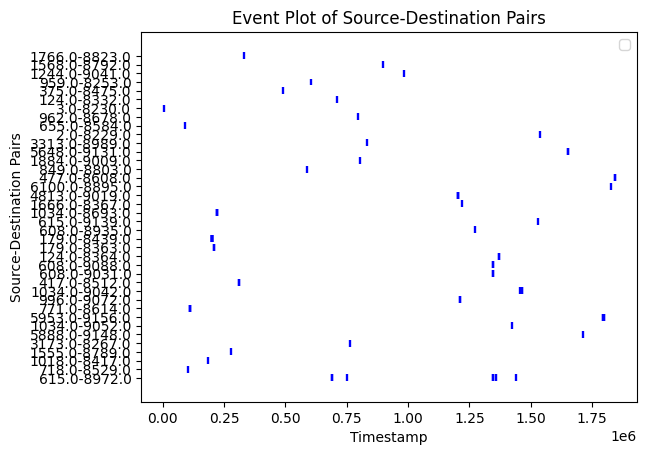

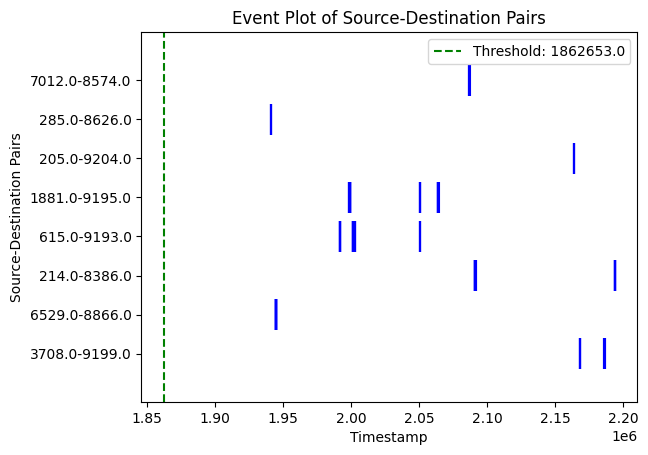

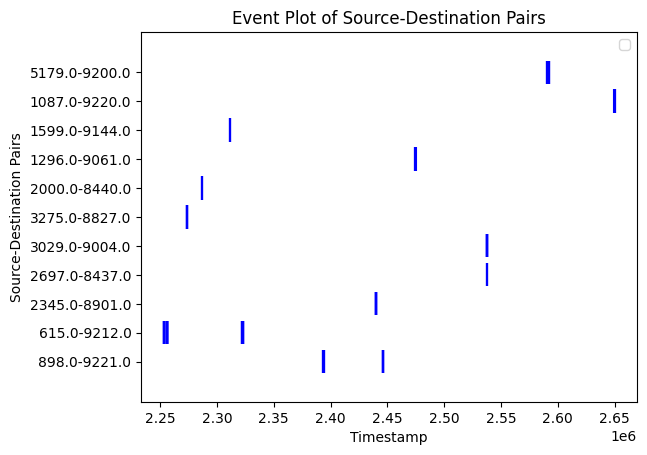

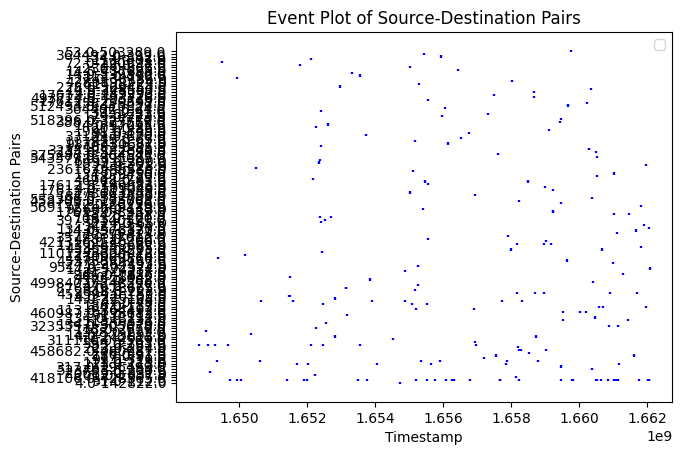

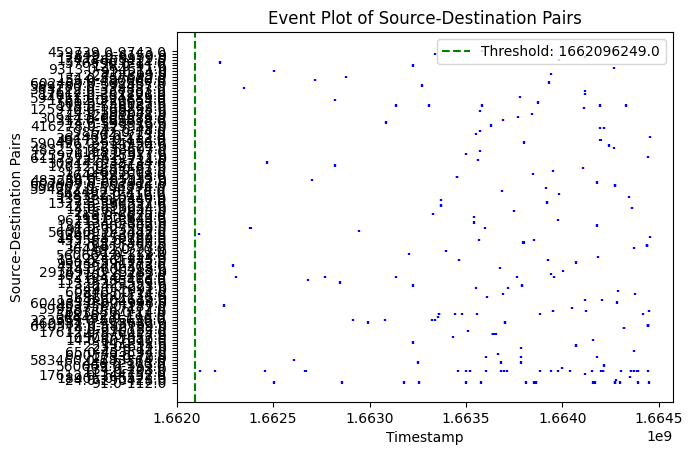

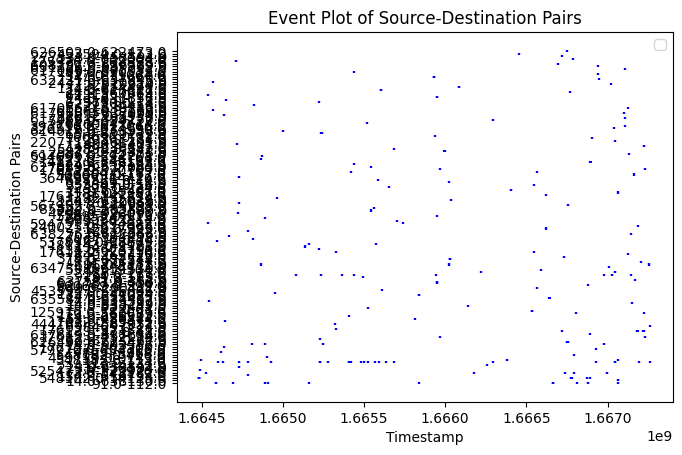

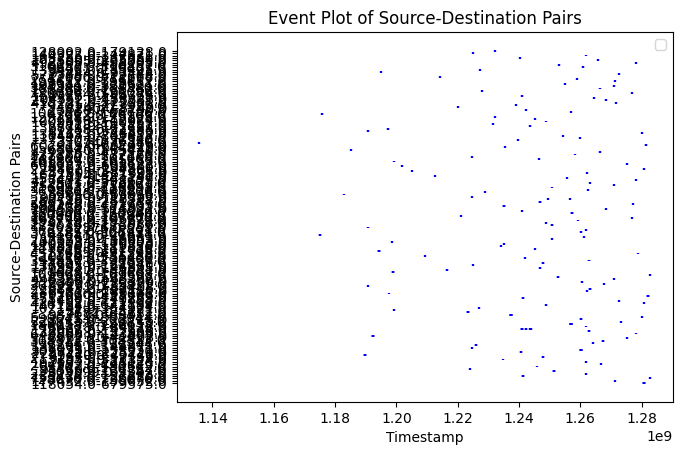

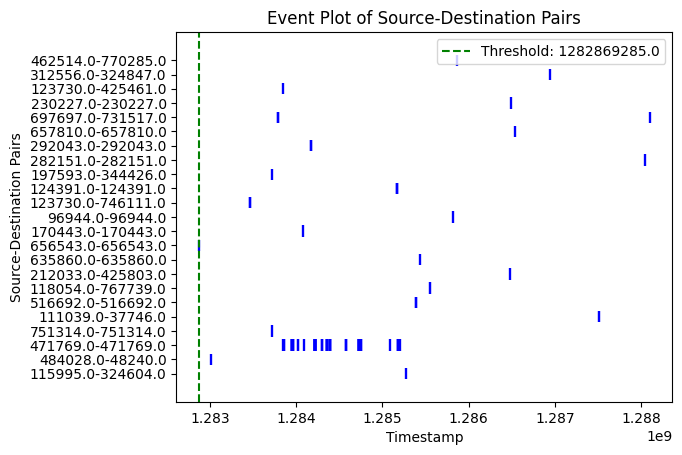

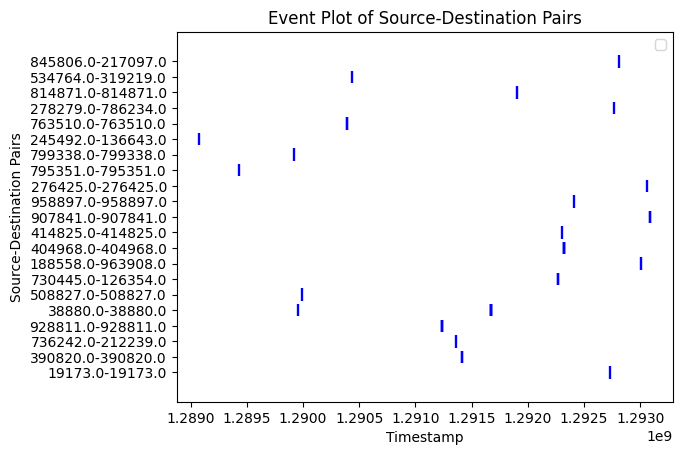

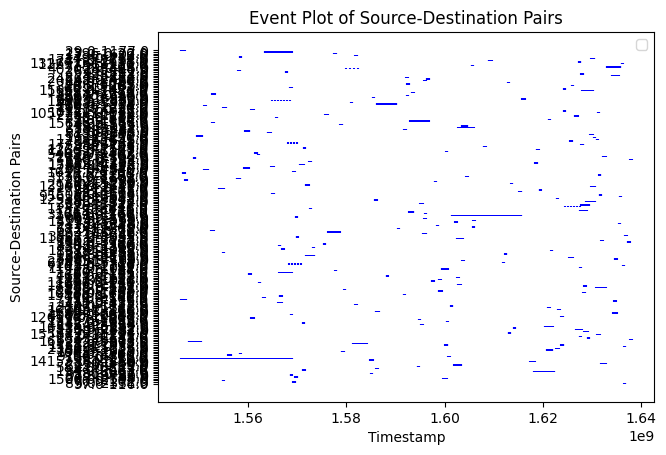

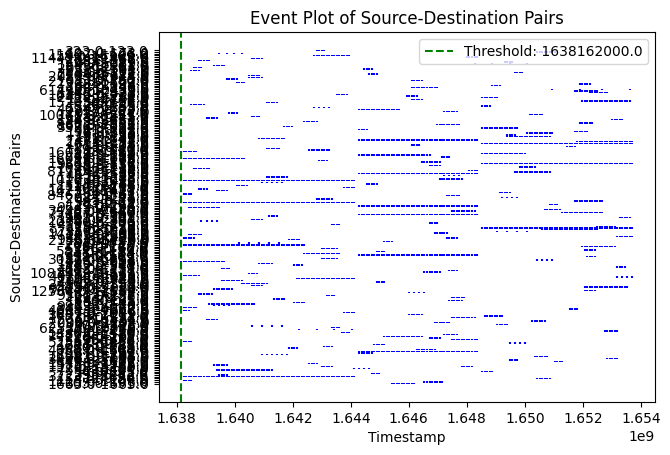

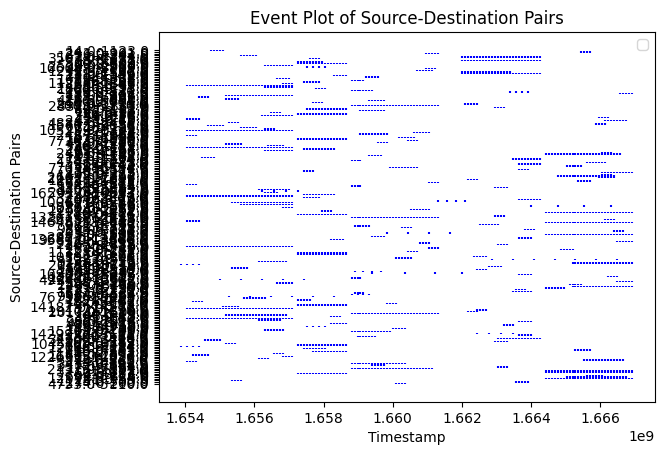

In [18]:
datasets = ['tgbl-wiki', 'tgbl-review', 'tgbl-coin', 'tgbl-comment', 'tgbl-flight']


for dataset_name in datasets:
    file_name = dataset_name + '_data_df.pkl'

    with open(file_name, 'rb') as file:
        data_df = pickle.load(file)
    
    data_df = create_base_df(dataset_name)
    subset_df, train_subset_df, val_subset_df, test_subset_df, perc_edges_checked, validation_timestamp = create_subset_df(data_df)
    
    subsets_df_list = [train_subset_df, val_subset_df, test_subset_df]
    subset_names = ['_train', '_train_val', '_test']
    
    for i in range(len(subset_names)):
        file_name_recurrent = dataset_name + subset_names[i] + '_recurrency_df.pkl'
        with open(file_name_recurrent, 'rb') as file:
            subset_df_recurrent = pickle.load(file)

        #print(subset_df_recurrent)
        if len(subset_df_recurrent) == 0:
            continue
                        
        perc_recurrent_edges = len(subset_df_recurrent) / len(subsets_df_list[i])* 100
        print(f'In {dataset_name}{subset_names[i]}, {perc_recurrent_edges} % of edges are recurrent. ')

        # of source-destination pairs that show recurrency in the test set 
        perc_recurrent_SD_pairs = len(subset_df_recurrent.groupby(['Source', 'Destination'])) / len(subsets_df_list[i].groupby(['Source', 'Destination'])) * 100
        print(f'In {dataset_name}{subset_names[i]}, {perc_recurrent_SD_pairs} % of source-destination nodes show recurrency. ')


        plot_recurrent_samples(subset_df_recurrent, dataset_name, subset_names[i], validation_timestamp)
        


In [ ]:

file_name = 'tgbl-wiki_train_recurrency_df.pkl'
with open(file_name, 'rb') as file:  # Ensure this is 'rb' for read-binary
    train_rec_df = pickle.load(file)

file_name = 'tgbl-wiki_train_val_recurrency_df.pkl'
with open(file_name, 'rb') as file:  # Ensure this is 'rb' for read-binary
    train_val_rec_df = pickle.load(file)


file_name = 'tgbl-wiki_test_recurrency_df.pkl'
with open(file_name, 'rb') as file:  # Ensure this is 'rb' for read-binary
    test_rec_df = pickle.load(file)

In [ ]:
recurrent_df_list = [train_rec_df, train_val_rec_df, test_rec_df]
combined_recurrent_df = pd.concat(recurrent_df_list)
combined_recurrent_df = combined_recurrent_df.groupby(['Source', 'Destination'])['Timestamps'].agg(sum).apply(sorted).reset_index()
combined_recurrent_df = combined_recurrent_df[['Source', 'Destination', 'Timestamps']]
combined_recurrent_df = combined_recurrent_df.explode('Timestamps').reset_index(drop=True)
combined_recurrent_df = combined_recurrent_df.rename(columns={'Timestamps': 'Timestamp'})


file_name_save = name + '_combined_recurrency_df.pkl'
with open( file_name_save , 'wb') as file: 
    pickle.dump(combined_recurrent_df, file) 

threshold = val_df['Timestamp'].min()
file_path = name + '_final_results.pkl'
results = relative_recurrency_comp(subset_df, combined_recurrent_df, threshold, file_path)
print(results)


import pickle

def relative_recurrency_comp(subset_df, combined_recurrent_df, val_threshold, file_path):
    results = {}

    # Convert 'Timestamp' in combined_recurrent_df to list for compatibility in comparisons
    combined_recurrent_df['Timestamp'] = combined_recurrent_df['Timestamp'].apply(lambda x: [x])
    
    # Concatenate and sort timestamps for recurrent interactions, group by 'Source' and 'Destination'
    combined_recurrent = combined_recurrent_df.groupby(['Source', 'Destination'])['Timestamp'].sum().apply(sorted).reset_index()

    # Calculate total counts
    total_edges = len(subset_df)
    total_pairs = subset_df.groupby(['Source', 'Destination']).ngroups
    total_recurrent_edges = len(combined_recurrent_df)
    total_recurrent_pairs = combined_recurrent.groupby(['Source', 'Destination']).ngroups

    # Calculate recurrent interactions for each category
    training_only = subset_df[subset_df.groupby(['Source', 'Destination'])['Timestamp'].transform('max') < val_threshold]
    train_and_val = subset_df.groupby(['Source', 'Destination']).filter(lambda x: x['Timestamp'].min() < val_threshold and x['Timestamp'].max() > val_threshold)
    test_only = subset_df[subset_df.groupby(['Source', 'Destination'])['Timestamp'].transform('min') > val_threshold]

    # Identify recurrent interactions within each category
    training_only_recurrent = pd.merge(training_only, combined_recurrent, on=['Source', 'Destination'], how='inner')
    train_and_val_recurrent = pd.merge(train_and_val, combined_recurrent, on=['Source', 'Destination'], how='inner')
    test_only_recurrent = pd.merge(test_only, combined_recurrent, on=['Source', 'Destination'], how='inner')

    # Calculate percentages
    results['% recurrent interactions overall'] = total_recurrent_edges / total_edges * 100
    results['% recurrent interactions only in training'] = len(training_only_recurrent) / max(len(training_only), 1) * 100
    results['% recurrent interactions in train to val'] = len(train_and_val_recurrent) / max(len(train_and_val), 1) * 100
    results['% recurrent interactions only in test'] = len(test_only_recurrent) / max(len(test_only), 1) * 100

    # Calculate percentages for unique source-destination pairs
    results['% recurrent pairs overall'] = total_recurrent_pairs / total_pairs * 100
    results['% recurrent pairs only in training'] = training_only_recurrent.groupby(['Source', 'Destination']).ngroups / max(training_only.groupby(['Source', 'Destination']).ngroups, 1) * 100
    results['% recurrent pairs in train to val'] = train_and_val_recurrent.groupby(['Source', 'Destination']).ngroups / max(train_and_val.groupby(['Source', 'Destination']).ngroups, 1) * 100
    results['% recurrent pairs only in test'] = test_only_recurrent.groupby(['Source', 'Destination']).ngroups / max(test_only.groupby(['Source', 'Destination']).ngroups, 1) * 100

    # Pickle the results dictionary
    with open(file_path, 'wb') as handle:
        pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

    return results

# Example usage
# val_threshold = your_threshold_value
# file_path = 'relative_recurrency_results.pkl'
# results = relative_recurrency_comp(subset_df, combined_recurrent_df, val_threshold, file_path)
# print(results)


import pickle

def relative_recurrency_comp(subset_df, combined_sorted_df, val_threshold, file_path):
    results = {}
    
    # Helper function to calculate the stats
    def calculate_stats(df, threshold):
        stats = {}
        total_edges = len(df)
        total_pairs = df.groupby(['Source', 'Destination']).ngroups

        training_only_groups = df[df.groupby(['Source', 'Destination'])['Timestamp'].transform('max') < threshold]
        train_val_groups = df.groupby(['Source', 'Destination']).filter(lambda x: x['Timestamp'].min() < threshold and x['Timestamp'].max() > threshold)
        test_only_groups = df[df.groupby(['Source', 'Destination'])['Timestamp'].transform('min') > threshold]

        stats['total_edges'] = total_edges
        stats['% interactions only in training'] = len(training_only_groups) / total_edges * 100
        stats['% interactions in train to val'] = len(train_val_groups) / total_edges * 100
        stats['% interactions only in test'] = len(test_only_groups) / total_edges * 100
        stats['% unique pairs only in training'] = training_only_groups.groupby(['Source', 'Destination']).ngroups / total_pairs * 100
        stats['% unique pairs in train to val'] = train_val_groups.groupby(['Source', 'Destination']).ngroups / total_pairs * 100
        stats['% unique pairs only in test'] = test_only_groups.groupby(['Source', 'Destination']).ngroups / total_pairs * 100

        return stats

    # Calculate stats for subset_df and combined_sorted_df
    results['normal'] = calculate_stats(subset_df, val_threshold)
    results['recurrent'] = calculate_stats(combined_sorted_df, val_threshold)

    # Pickle the results dictionary
    with open(file_path, 'wb') as handle:
        pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

    return results




def relative_recurrency_comp(subset_df, combined_sorted_df, val_threshold, file_path):
    results = {}

    total_edges = len(subset_df)
    training_only = sum(subset_df.groupby(['Source', 'Destination'])['Timestamp'].max() < val_threshold)
    grouped = subset_df.groupby(['Source', 'Destination'])['Timestamp'].agg(['min', 'max'])
    filtered_groups = grouped[(grouped['min'] < val_threshold) & (grouped['max'] > val_threshold)]
    train_and_val = len(filtered_groups)
    test_only = sum(subset_df.groupby(['Source', 'Destination'])['Timestamp'].min() > val_threshold)

    results['% interactions only in training'] = training_only / total_edges * 100
    results['% interactions in train to val'] = train_and_val / total_edges * 100
    results['% interactions only in test'] = test_only / total_edges * 100

    total_recurrent_edges = len(combined_sorted_df)
    training_only_rec = sum(combined_sorted_df.groupby(['Source', 'Destination'])['Timestamps'].max() < val_threshold)
    grouped_rec = combined_sorted_df.groupby(['Source', 'Destination'])['Timestamps'].agg(['min', 'max'])
    filtered_groups_rec = grouped_rec[(grouped_rec['min'] < val_threshold) & (grouped_rec['max'] > val_threshold)]
    train_and_val_rec = len(filtered_groups_rec)
    test_only_rec = sum(combined_sorted_df.groupby(['Source', 'Destination'])['Timestamps'].min() > val_threshold)

    results['% recurrent interactions overall'] = total_recurrent_edges / total_edges * 100
    results['% recurrent interactions only in training'] = training_only_rec / max(training_only, 1)  * 100
    results['% recurrent interactions in train to val'] = train_and_val_rec / max(train_and_val, 1)  * 100
    results['% recurrent interactions only in test'] = test_only_rec / max(test_only, 1) * 100

    # Pickle the results dictionary
    with open(file_path, 'wb') as handle:
        pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

    return results






### Let's find out the list of 'context' time windows for a model that looks at the last n interactions for each node-node/S-D pair


In [163]:


def sample_source_destination_pairs(df, seq_length, N=100):
    np.random.seed(10)
    # Ensure the DataFrame is sorted if sequence order matters for later operations
    df.sort_values(by='Timestamp', ascending=True, inplace=True)
    
    # Count the number of records for each source-destination pair
    counts = df.groupby(['Source', 'Destination']).size()
    
    # Filter pairs that have at least seq_length records
    eligible_pairs = counts[counts >= seq_length].index.tolist()
    
    # Randomly sample N of these pairs, if there are enough eligible pairs
    if len(eligible_pairs) > N:
        sampled_pairs = np.random.choice(range(len(eligible_pairs)), size=N, replace=False)
        selected_pairs = [eligible_pairs[i] for i in sampled_pairs]
    else:
        print("Not enough eligible pairs to sample from, reducing N to the number of eligible pairs.")
        selected_pairs = eligible_pairs
    
   # Extract data for these sampled pairs
    sampled_dfs = [df[(df['Source'] == pair[0]) & (df['Destination'] == pair[1])] for pair in selected_pairs]
    
    # Check if the list of DataFrames is not empty before concatenating
    if sampled_dfs:
        sampled_data = pd.concat(sampled_dfs)
    else:
        print("No data matched the sampled pairs. Returning an empty DataFrame.")
        sampled_data = pd.DataFrame(columns=df.columns)  # Return an empty DataFrame with the same columns as the input df
    
    return sampled_data




In [164]:
def compute_efficient_time_diffs(df, seq_length):
    df = df.copy()
    df.sort_values(by='Timestamp', ascending=True, inplace=True)  # Ensure chronological order

    latest_timestamp = df['Timestamp'].max()

    # Use groupby and apply to calculate the nth last timestamp for each group, ensuring we have enough records
    agg_df = df.groupby(['Source', 'Destination']).apply(
        lambda x: x.iloc[-seq_length] if len(x) >= seq_length else pd.Series(np.nan, index=x.columns)
    ).reset_index(drop=True)

    # Drop rows with NaN values, which represent groups with fewer than seq_length events
    agg_df = agg_df.dropna(subset=['Timestamp'])


    # Calculate the time difference
    agg_df['time_diff'] = latest_timestamp - agg_df['Timestamp']

    # Filter out any groups that didn't have an nth event
    valid_diffs = agg_df.dropna(subset=['time_diff'])

    # Convert the time_diff from the raw numeric difference to a more interpretable format if necessary
    valid_diffs['time_diff_td'] = pd.to_timedelta(valid_diffs['time_diff'], unit='s')

    average_period = valid_diffs['time_diff_td'].mean() if not valid_diffs.empty else pd.Timedelta(0)
    median_period = valid_diffs['time_diff_td'].median() if not valid_diffs.empty else pd.Timedelta(0)

    return valid_diffs[['time_diff']], average_period, median_period


In [165]:
import pandas as pd

def convert_timedelta(timedelta):
    # Extract total number of days and seconds from the Timedelta
    total_days = timedelta.days
    total_seconds = timedelta.seconds
    
    # Constants for conversions
    days_in_a_year = 365
    seconds_in_a_minute = 60
    seconds_in_an_hour = 3600
    seconds_in_a_day = 86400
    
    # Convert total_days to years and remaining days
    years = total_days // days_in_a_year
    remaining_days = total_days % days_in_a_year
    
    # Calculate hours, minutes, and seconds from total_seconds
    hours = total_seconds // seconds_in_an_hour
    minutes = (total_seconds % seconds_in_an_hour) // seconds_in_a_minute
    seconds = total_seconds % seconds_in_a_minute
    
    return years, remaining_days, hours, minutes, seconds

# Example usage with a pandas Timedelta
timedelta_example = pd.Timedelta('519 days 19:00:43.200000')
convert_timedelta(timedelta_example)


(1, 154, 19, 0, 43)

In [166]:
import pandas as pd
import numpy as np

# Seed for reproducibility
np.random.seed(42)

# Generate a synthetic dataset
n_rows = 1000  # Number of rows

# Randomly generate 'Source' and 'Destination' from a list of cities
source = ['1'] * (n_rows//2) + ['2'] * (n_rows//2)
destination = ['1'] * (n_rows//2) + ['2'] * (n_rows//2)

# Generate 'Timestamp' as random timestamps within a specific range
timestamps = range(n_rows)

# Create the DataFrame
df = pd.DataFrame({'Source': source, 'Destination': destination, 'Timestamp': timestamps})

df.head()

compute_efficient_time_diffs(df, 2)

(   time_diff
 0        501
 1          1,
 Timedelta('0 days 00:04:11'),
 Timedelta('0 days 00:04:11'))

In [168]:
powers_2 = []
for i in range(3, 13):
    powers_2.append(2**i)

# Convert each integer in powers_2 to a string to use as keys
my_dict = {str(key): [] for key in powers_2}


N = 500  # Number of pairs to sample

for i in powers_2:
    seq_length = i  # Or whatever your sequence length requirement is
    #sampled_df = sample_source_destination_pairs(data_df, i, N)
    tot, ave, median = compute_efficient_time_diffs(data_df, i)
    my_dict[str(i)].append([tot, ave, median])
    print(f"For {i} we have an average {ave} ")



For 8 we have an average 13 days 10:34:30.871481481 
For 16 we have an average 13 days 23:00:34.022530329 
For 32 we have an average 15 days 09:16:00.323556370 
For 64 we have an average 17 days 02:20:17.464646464 
For 128 we have an average 17 days 19:57:33.142131979 
For 256 we have an average 18 days 23:17:25.026315789 
For 512 we have an average 19 days 23:10:49.750000 
For 1024 we have an average 26 days 14:51:32 
For 2048 we have an average 0 days 00:00:00 
For 4096 we have an average 0 days 00:00:00 


In [169]:
for i in powers_2:
    med = my_dict[str(i)][0][1]
    print(f"For {i} we have an median {convert_timedelta(med)} ")


For 8 we have an median (0, 13, 10, 34, 30) 
For 16 we have an median (0, 13, 23, 0, 34) 
For 32 we have an median (0, 15, 9, 16, 0) 
For 64 we have an median (0, 17, 2, 20, 17) 
For 128 we have an median (0, 17, 19, 57, 33) 
For 256 we have an median (0, 18, 23, 17, 25) 
For 512 we have an median (0, 19, 23, 10, 49) 
For 1024 we have an median (0, 26, 14, 51, 32) 
For 2048 we have an median (0, 0, 0, 0, 0) 
For 4096 we have an median (0, 0, 0, 0, 0) 


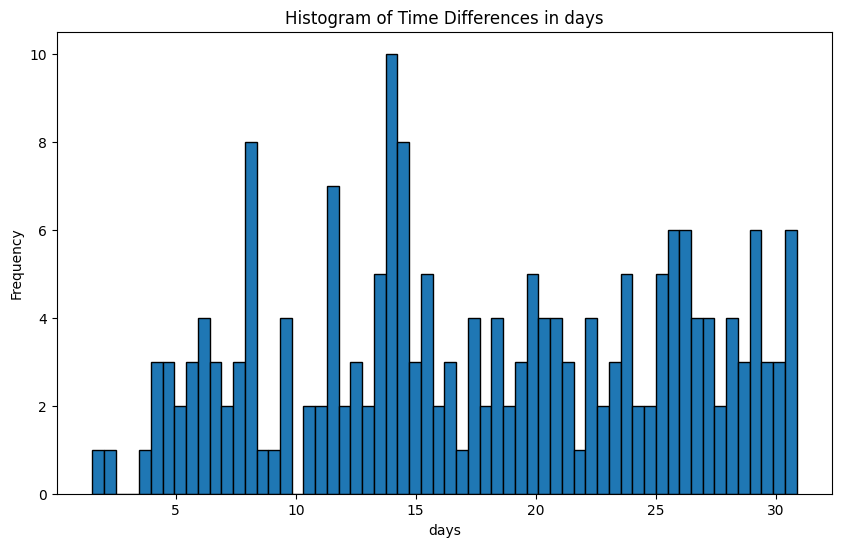

In [173]:
seq_to_plot = 128
days = []
for i in range(len(my_dict[str(seq_to_plot)][0][0])):
    days.append(my_dict[str(seq_to_plot)][0][0]['time_diff'].to_list()[i]/(86400) )


# Plotting the histogram
plt.figure(figsize=(10, 6))  # Optional: Specifies the figure size
plt.hist(days, bins=60, edgecolor='black')  # You can adjust the number of bins as needed

plt.title('Histogram of Time Differences in days')
plt.xlabel('days')
plt.ylabel('Frequency')

plt.show()

Older functions

In [ ]:
def compute_time_diffs(dataset_df, seq_length):
    dataset_df = dataset_df.copy()
    all_periods = []
    dataset_df['Timestamp'] = pd.to_datetime(dataset_df['Timestamp'], unit='s')
    dataset_df = dataset_df.sort_values(by='Timestamp', ascending=False)
    grouped = dataset_df.groupby(['Source', 'Destination'])

    for (source, destination), group in grouped:
        # Find all one-hop neighbours for source and destination
        source_neighbours = dataset_df[dataset_df['Source'] == source][['Destination', 'Timestamp']]
        dest_neighbours = dataset_df[dataset_df['Destination'] == destination][['Source', 'Timestamp']]
        
        # Select only the most recent seq_length first-hop interactions
        top_k_source_neighbours = source_neighbours.head(seq_length).copy()
        top_k_dest_neighbours = dest_neighbours.head(seq_length).copy()

        # Ensure there are enough interactions before calculating time differences
        if len(top_k_source_neighbours) > 1:
            source_time_diff = top_k_source_neighbours.iloc[0]['Timestamp'] - top_k_source_neighbours.iloc[-1]['Timestamp']
            all_periods.append(source_time_diff)

        if len(top_k_dest_neighbours) > 1:
            dest_time_diff = top_k_dest_neighbours.iloc[0]['Timestamp'] - top_k_dest_neighbours.iloc[-1]['Timestamp']
            all_periods.append(dest_time_diff)

    # Compute average of all periods, considering the possibility of having an empty list
    average_period = pd.to_timedelta(all_periods).mean() if all_periods else pd.Timedelta(0)
    return all_periods, average_period

#### Now subselect the node interactions that have recurrency from 2x the context window back from the validation split to beginning of validation data

the period for the recurrrency is anything that goes from the length of the context  window back from the validation switch to the validaiton switch 

strict in this sense means exactly every n timesteps

then we relax to say every n timesteps with some small noise around it 

as well as that it doesn't have to go for the WHOLE period, but needs to have at least K events (within or outside the context window )


In [216]:

final_df = find_sequences_optimized(data_df, 1000 , 10, 4, None)

What is the best way to quantify the recurrency within a dataset?





In [298]:
mock_df = data_df.copy()

,Source,Destination,min,max,mean,median,count
1,1.0,8228.0,20.0,548294.0,5009.464789,134.5,284
2,2.0,8229.0,9.0,341142.0,16203.645963,76.0,161
3,3.0,8230.0,27.0,605065.0,14122.686170,135.5,188
4,4.0,8231.0,12.0,667158.0,16187.252874,223.0,87
5,4.0,8725.0,12.0,949242.0,11719.661836,96.0,207
...,...,...,...,...,...,...,...
18233,8203.0,8260.0,228.0,764.0,472.333333,425.0,3
18240,8210.0,8454.0,79.0,79.0,79.000000,79.0,1
18244,8214.0,8250.0,115.0,115.0,115.000000,115.0,1
18248,8218.0,9222.0,66.0,342.0,192.333333,169.0,3


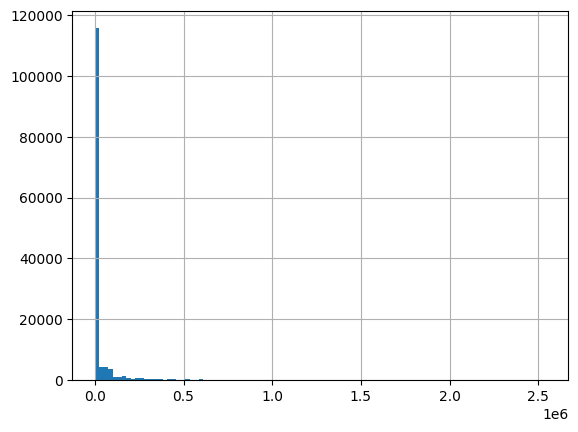

In [301]:
mock_df.sort_values(by=['Source', 'Destination', 'Timestamp'], inplace=True)
mock_df['TimeDiff'] = mock_df.groupby(['Source', 'Destination'])['Timestamp'].diff()
mock_df['TimeDiff'].hist(bins=100)

aggregated = mock_df.groupby(['Source', 'Destination'])['TimeDiff'].agg(['min', 'max', 'mean', 'median', 'count']).reset_index().dropna()
aggregated

In [324]:
sum(aggregated['count']>=4)/len(aggregated)*100

aggregated_high_count = aggregated[aggregated['count'] >= 4]

In [328]:
aggregated_high_count['median'].median()

622.0

In [299]:
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and 'Time_Diff' has been calculated

# First, let's generate a cumulative sum of 'Time_Diff' for each source-destination pair to represent event times
mock_df['Event_Time'] = mock_df.groupby(['Source', 'Destination'])['TimeDiff'].cumsum()

# Get unique source-destination pairs
source_destination_pairs = mock_df[['Source', 'Destination']].drop_duplicates()

fig, ax = plt.subplots()

for (idx, row) in source_destination_pairs.iterrows():
    source, destination = row['Source'], row['Destination']
    # Filter the DataFrame for the current source-destination pair
    subset_df = mock_df[(mock_df['Source'] == source) & (mock_df['Destination'] == destination)]
    event_times = subset_df['Event_Time'].tolist()
    
    # Generate a vertical line for each event time
    ax.eventplot(event_times, lineoffsets=idx, linelengths=0.8, label=f'{source} -> {destination}')

# Configure the plot
ax.set_title('Event Plot for Source-Destination Pairs')
ax.set_ylabel('Source-Destination Pair')
ax.set_xlabel('Time since first event (seconds)')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


KeyError: 'Column not found: TimeDiff'

In [252]:
def get_primes_up_to_x(x):
    """
    Returns a list of prime numbers up to x.

    Parameters:
    - x: The upper limit (inclusive) to search for prime numbers.

    Returns:
    - A list of prime numbers up to x.
    """
    if x < 2:  # There are no prime numbers less than 2
        return []
    
    # Initialize a list to mark non-prime numbers
    is_prime = [True] * (x + 1)
    is_prime[0] = is_prime[1] = False  # 0 and 1 are not prime numbers
    
    primes = []
    for number in range(2, int(x**0.5) + 1):  # Only go up to the square root of x
        if is_prime[number]:
            primes.append(number)
            # Mark multiples of this prime as non-prime
            for multiple in range(number*number, x + 1, number):
                is_prime[multiple] = False
    
    # Append remaining prime numbers
    primes.extend([number for number in range(int(x**0.5) + 1, x + 1) if is_prime[number]])
    
    return primes


,Source,Destination,min,max,mean,median
1,1.0,8228.0,20.0,548294.0,5009.464789,134.5
2,2.0,8229.0,9.0,341142.0,16203.645963,76.0
3,3.0,8230.0,27.0,605065.0,14122.686170,135.5
4,4.0,8231.0,12.0,667158.0,16187.252874,223.0
5,4.0,8725.0,12.0,949242.0,11719.661836,96.0
...,...,...,...,...,...,...
18233,8203.0,8260.0,228.0,764.0,472.333333,425.0
18240,8210.0,8454.0,79.0,79.0,79.000000,79.0
18244,8214.0,8250.0,115.0,115.0,115.000000,115.0
18248,8218.0,9222.0,66.0,342.0,192.333333,169.0


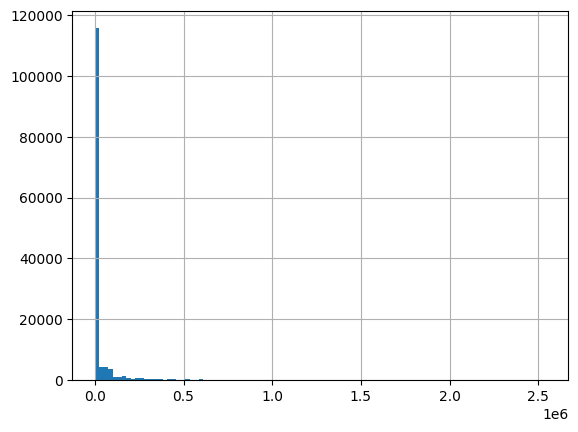

KeyError: 'Column not found: Time_Diff'

In [248]:
from scipy.stats import gaussian_kde
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

def find_high_density_ranges(time_diffs, bandwidth=0.1):
    """
    Finds high-density ranges of time differences using KDE.
    Returns a list of tuples indicating the start and end of high-density ranges.
    """
    kde = gaussian_kde(time_diffs, bw_method=bandwidth)
    x_grid = np.linspace(time_diffs.min(), time_diffs.max(), 1000)
    kde_estimates = kde.evaluate(x_grid)
    
    # For simplicity, let's consider the top 20% of densities as "high-density"
    cutoff = np.quantile(kde_estimates, 0.8)
    high_density = x_grid[kde_estimates >= cutoff]
    
    # Finding continuous ranges within the high-density intervals
    high_density_diff = np.diff(high_density)
    range_breaks = np.where(high_density_diff > np.mean(high_density_diff))[0]
    ranges = []
    start = high_density[0]
    for break_point in range_breaks:
        end = high_density[break_point]
        ranges.append((start, end))
        start = high_density[break_point + 1]
    ranges.append((start, high_density[-1]))  # Add the last range
    
    return ranges

In [250]:
high_density_ranges = find_high_density_ranges(data_df['TimeDiff'].dropna())
high_density_ranges

In [256]:
def sample_primes_based_on_timediffs(high_density_ranges):
    all_primes = []
    for start, end in high_density_ranges:
        all_primes.extend(get_primes_up_to_x(int(end)))
    all_primes = list(set(all_primes))  # Remove duplicates
    all_primes = [p for p in all_primes if any(start <= p <= end for start, end in high_density_ranges)]
    all_primes.sort()
    return all_primes

n_range = sample_primes_based_on_timediffs(high_density_ranges)
n_range

[2,
 3,
 5,
 7,
 11,
 13,
 17,
 19,
 23,
 29,
 31,
 37,
 41,
 43,
 47,
 53,
 59,
 61,
 67,
 71,
 73,
 79,
 83,
 89,
 97,
 101,
 103,
 107,
 109,
 113,
 127,
 131,
 137,
 139,
 149,
 151,
 157,
 163,
 167,
 173,
 179,
 181,
 191,
 193,
 197,
 199,
 211,
 223,
 227,
 229,
 233,
 239,
 241,
 251,
 257,
 263,
 269,
 271,
 277,
 281,
 283,
 293,
 307,
 311,
 313,
 317,
 331,
 337,
 347,
 349,
 353,
 359,
 367,
 373,
 379,
 383,
 389,
 397,
 401,
 409,
 419,
 421,
 431,
 433,
 439,
 443,
 449,
 457,
 461,
 463,
 467,
 479,
 487,
 491,
 499,
 503,
 509,
 521,
 523,
 541,
 547,
 557,
 563,
 569,
 571,
 577,
 587,
 593,
 599,
 601,
 607,
 613,
 617,
 619,
 631,
 641,
 643,
 647,
 653,
 659,
 661,
 673,
 677,
 683,
 691,
 701,
 709,
 719,
 727,
 733,
 739,
 743,
 751,
 757,
 761,
 769,
 773,
 787,
 797,
 809,
 811,
 821,
 823,
 827,
 829,
 839,
 853,
 857,
 859,
 863,
 877,
 881,
 883,
 887,
 907,
 911,
 919,
 929,
 937,
 941,
 947,
 953,
 967,
 971,
 977,
 983,
 991,
 997,
 1009,
 1013,
 1019,


In [261]:
max(n_range) / data_df['TimeDiff'].max()*100

23.92351591753487

In [277]:
print(len(n_range))
subsampled_n_range = n_range[2::100]
print(len(subsampled_n_range))

41604
417


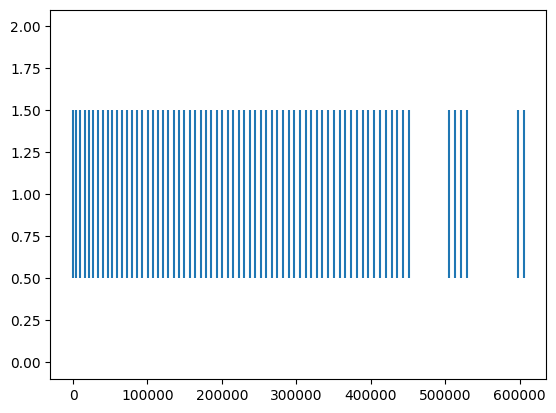

In [273]:
plt.eventplot(subsampled_n_range)

5
563
1237
1999
2767
3593
4441
5303
6163
7019
7937
8849
9749
10687
11689
12583
13537
14543
15439
16421
17417
18353
19433
20389
21401
22367
23339
24337
25423
26423
27481
28537
29483
30631
31643
32633
33623
34673
35801
36793
37853
38953
39989
41131
42101
43093
44221
45329
46471
47563
48647
49681
50777
51829
52957
54013
55127
56209
57221
58309
59387
60527
61651
62819
63841
65099
66137
67271
68437
69539
70687
71761
72871
74021
75133
76243
77377
78509
79633
80749
81847
82939
84143
85259
86399
87583
88813
89897
91009
92189
93229
94397
95467
96601
97843
98981
100153
101323
102359
103643
104761
105971
107069
108289
109433
110623
111821
113017
114161
115337
116483
117701
118861
120017
121157
122273
123479
124643
125789
127033
128213
129293
130477
131713
132863
134081
135301
136399
137507
138679
139939
141079
142193
143513
144757
145963
147151
148381
149459
150611
151733
152909
154157
155377
156623
157771
159073
160207
161453
162683
163859
165103
166393
167521
168893
170063
171233
172421
173669


,Source,Destination,Number_of_Events,Timestamps,N,Noise_value
0,205.0,9204.0,4,"[2125717.0, 2126325.0, 2126918.0, 2127476.0]",563,56.3
1,1074.0,9056.0,4,"[2463818.0, 2464384.0, 2464978.0, 2465491.0]",563,56.3
2,1101.0,8758.0,4,"[350217.0, 350725.0, 351329.0, 351902.0]",563,56.3
3,2552.0,9166.0,4,"[2513962.0, 2514507.0, 2515033.0, 2515638.0]",563,56.3
4,3532.0,8540.0,4,"[858843.0, 859441.0, 860012.0, 860563.0]",563,56.3
...,...,...,...,...,...,...
589,4116.0,8801.0,4,"[985641.0, 1385003.0, 1733737.0, 2110784.0]",381389,38138.9
590,4116.0,8801.0,4,"[985641.0, 1385003.0, 1733737.0, 2110784.0]",382751,38275.1
591,4116.0,8801.0,4,"[985641.0, 1385003.0, 1733737.0, 2110784.0]",383987,38398.7
592,4116.0,8801.0,4,"[985641.0, 1385003.0, 1733737.0, 2110784.0]",385261,38526.1


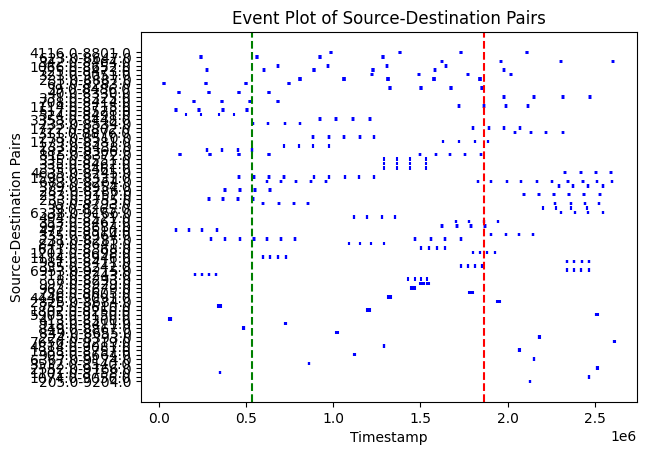

<Axes: >

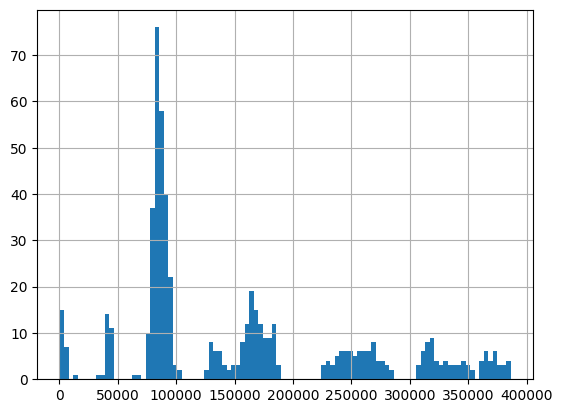

In [335]:
from scipy.stats import pearsonr

# Assuming final_df is your DataFrame
correlations = []

# Iterate over the DataFrame by index to compare unique pairs
for i in range(len(final_df)):
    for j in range(i + 1, len(final_df)):  # Start from i + 1 to avoid self-comparison
        # Extract source and destination IDs for both pairs
        source_i, dest_i = final_df.iloc[i]['Source'], final_df.iloc[i]['Destination']
        source_j, dest_j = final_df.iloc[j]['Source'], final_df.iloc[j]['Destination']

        # Ensure you're not comparing the same source-destination pair
        if (source_i, dest_i) != (source_j, dest_j):
            timestamps_i = final_df.iloc[i]['Timestamps']
            timestamps_j = final_df.iloc[j]['Timestamps']
            
            # Ensure the lists have the same length by truncating to the shorter length
            min_length = min(len(timestamps_i), len(timestamps_j))
            timestamps_i = timestamps_i[:min_length]
            timestamps_j = timestamps_j[:min_length]

            # Calculate Pearson correlation if both lists have at least one element after truncation
            if min_length > 0:
                corr, _ = pearsonr(timestamps_i, timestamps_j)
                correlations.append(((source_i, dest_i, source_j, dest_j), corr))

# Sort by absolute correlation value to find the highest correlations
correlations.sort(key=lambda x: abs(x[1]), reverse=True)

# Print the top correlations, ensuring to show unique pairs only
for pair, corr in correlations[:5]:  # Adjust as needed to see more or fewer results
    print(f"Pairs {pair} have a correlation of {corr}")


Pairs (335.0, 8462.0, 335.0, 8551.0) have a correlation of 0.999999911278451
Pairs (335.0, 8461.0, 335.0, 8462.0) have a correlation of 0.9999998738496194
Pairs (335.0, 8461.0, 335.0, 8551.0) have a correlation of 0.9999996833433169
Pairs (736.0, 8605.0, 517.0, 8528.0) have a correlation of 0.9999995703586639
Pairs (736.0, 8605.0, 517.0, 8528.0) have a correlation of 0.9999995703586639


In [ ]:
def event_synchronization(series_a, series_b, tau):
    """
    Calculate the synchronization score between two event series.
    
    Parameters:
    - series_a: list of event times (int or float) for series A
    - series_b: list of event times (int or float) for series B
    - tau: maximum time lag (int or float) for events to be considered synchronized
    
    Returns:
    - sync_score: synchronization score between series A and B
    """
    sync_events = 0  # Counter for synchronized events
    
    # Iterate through each event in series A
    for event_a in series_a:
        # Check if there's at least one event in series B that is synchronized with event_a
        for event_b in series_b:
            if abs(event_a - event_b) <= tau:
                sync_events += 1
                break  # Stop checking after finding the first synchronized event
    
    # Normalize by the average number of events in the two series
    average_events = (len(series_a) + len(series_b)) / 2
    sync_score = sync_events / average_events
    
    return sync_score


In [ ]:
event_synchronization

In [189]:
import pandas as pd
import numpy as np

# Parameters for synthetic data
n = 10  # Target interval
noise_percent = 10  # Noise percentage
k = 3  # Minimum number of consecutive events
timestamp_threshold = 50  # Threshold timestamp
n_start = 10
n_end = 10
n_step = 3


# Synthetic data
data = {
    'Source': [1, 1, 1, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6, 6, 6, 6],
    'Destination': [1, 1, 1, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6,7, 7, 7],
    'Timestamp': [
        10, 20, 30,  # Sequence entirely before threshold, consecutive, same src-dest
        60, 70, 80,  # Sequence entirely after threshold, consecutive, same src-dest
        40, 49, 58, 67, 76,  # Sequence spanning the threshold, consecutive, should be picked
        10, 21, 33,  # Sequence before threshold, not consecutive
        61, 73, 85,  # Sequence after threshold, not consecutive
        39, 51, 63,  # Sequence spanning the threshold but not consecutive enough
        37, 47, 58  # Sequence spanning the threshold, consecutive, should be picked, different src-dest
    ]
}
df = pd.DataFrame(data)


debug_data = {
    'Source': [7, 7, 7],
    'Destination': [7, 7, 7],
    'Timestamp': [37, 47, 58],  # Sequence in question
}

debug_df = pd.DataFrame(debug_data)


# Assuming the function find_sequences_across_range_with_threshold is correctly defined and available
results_df = find_sequences_across_range_with_threshold(df, n_start, n_end, n_step, noise_percent, k, timestamp_threshold)

#results_df = find_sequences_optimized(df, n,noise_percent, k,  timestamp_threshold)
results_df



10
Valid Group IDs: [ 2 11]


,Source,Destination,Number_of_Events,Timestamps,N,Noise_value
0,3,3,5,"[40, 49, 58, 67, 76]",10,1.0
1,6,7,3,"[37, 47, 58]",10,1.0


Now we have the dataset for wiki in a beautiful source, destination, timestamp format...

Things we can look at:

**Network based features**

- What kind of network is it? what do the nodes mean? bipartite

Across the network 
- What is the distribution of user activity? do some users dominate the action?
- What is the distribution of product node activity? are some products way more popular than others?
- What is the general activity  over time? is it relatively stable, or increase, decrease etc. How much of this is dominated by few users doing lots vs many users doing a bit? 

How do these measure change over time?

**For each user**

- Do they pick lots of different products or few? (CDF of unique edges for each user node)


**For each product**

- are popular products popular because lots of people are interested or a few are VERY interested? (CDF of unique edges for each product)


**For each user-product interaction**

- what sort of temporal interactions occur? 
- How many users repeatedly pick on previous products/pages? 
For example do users interact a lot in a short period with one product then drop it, 
or relatively often but for longer period, 
or in periodic (burst of) activity? 

=> CDF of time diff for each source-destination pair
=> Hist of time diff for each source-destination pair 
=> time-destination plot coloured by source 




**Which users behave most similarly?**
how much can one users's activity be explained/predicted by other users?
How independent is the actions of users? are users influenced by other users?



##### NETWORK BASED

**Wikipedia**
stores the co-editing network on Wikipedia pages over one month. The network is a bipartite interaction network where editors and wiki pages are nodes, while one edge represents a given user edits a page at a specific timestamp. Each edge has text features from the page edits.

users 8,227 
items 1,000 
interactions 157,474
state changes 217 : node features, predicting if a user will be banned 
action repetition 61% how repetitive users are (% of users that edit similar pages over time)


Prediction task: The task for this dataset is to predict with which wiki page a user will interact at a given time



<Axes: >

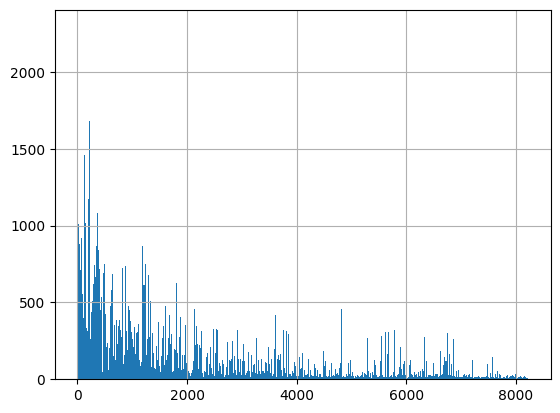

In [ ]:
## DISTRIBUTION OF USER ACTIVITY averaged over the FULL TIME 

data_df['Source'].hist(bins=1000)

<Axes: >

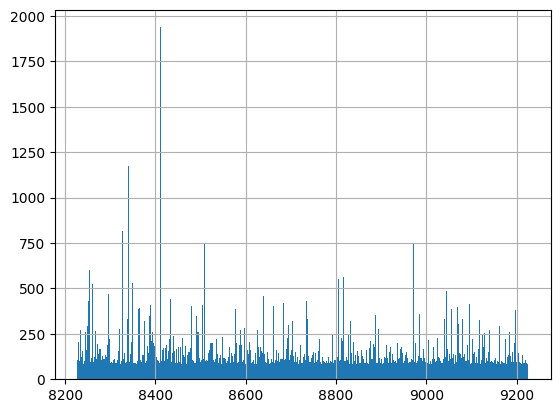

In [ ]:
## DISTRIBUTION OF PRODUCT/DESTINATION ACTIVITY averaged over the FULL TIME 

data_df['Destination'].hist(bins=1000)

<Axes: >

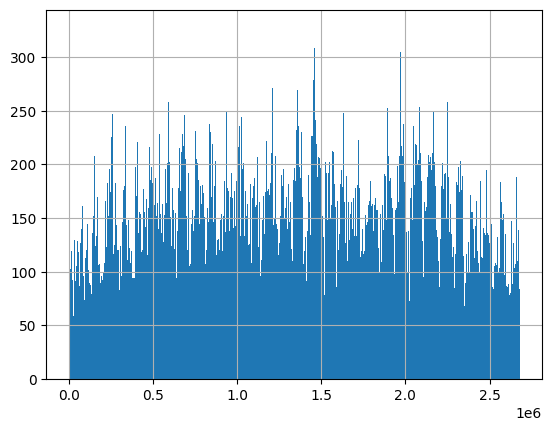

In [ ]:
## DISTRIBUTION OF TIME EVENTS 

data_df['Timestamp'].hist(bins=1000)

#### USER BASED
- Do users pick lots of different products or few? How many distinct products are there for each user!?
- What % of users pick n nodes throughout the timeframe?


=> CDF of distinct prodcts per user 
=> histogram of distinct prducts per user 

In [34]:

def plot_cdf(data_df, column_name, log_scale=False, title='CDF Plot', xlabel='Value', ylabel='CDF'):
    """
    Plots the CDF of a specified column in the given DataFrame.
    
    Parameters:
    - data_df: DataFrame containing the data.
    - column_name: The name of the column for which to plot the CDF.
    - log_scale: Whether to use a logarithmic scale for the x-axis. Default is False.
    - title: The title of the plot. Default is 'CDF Plot'.
    - xlabel: The label for the x-axis. Default is 'Value'.
    - ylabel: The label for the y-axis. Default is 'CDF'.
    """
    # Ensure the column exists in the DataFrame
    if column_name not in data_df.columns:
        raise ValueError(f"Column '{column_name}' not found in DataFrame.")
    
    # Prepare the data for CDF plot
    sorted_df = data_df.sort_values(by=column_name).reset_index(drop=True)
    sorted_df['cdf'] = sorted_df[column_name].rank(method='average', pct=True)

    # Plotting the CDF
    plt.figure(figsize=(8, 6))
    plt.plot(sorted_df[column_name], sorted_df['cdf'], marker='.', linestyle='none')

    if log_scale:
        plt.xscale('log')  # Set the x-axis to a logarithmic scale

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)

    plt.show()

# Example usage
# plot_cdf(dest_counts_df, 'UniqueDestCount', log_scale=True, title='CDF of number of events for user-product pair', xlabel='Edge counts for user-product pair', ylabel='CDF')


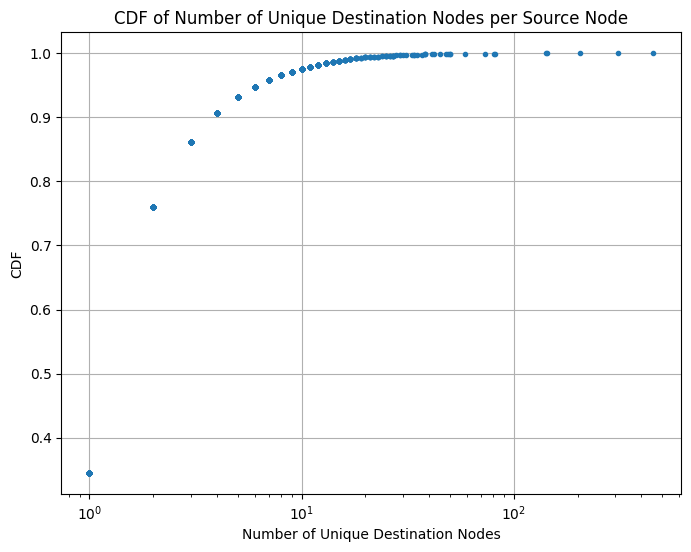

In [ ]:
dest_counts_per_source = data_df.groupby('Source')['Destination'].nunique()

# Convert the series to a DataFrame for easier manipulation
dest_counts_df = dest_counts_per_source.reset_index(name='UniqueDestCount')

plot_cdf(dest_counts_df, 'UniqueDestCount', log_scale=True, title='CDF of Number of Unique Destination Nodes per Source Node', xlabel='Number of Unique Destination Nodes', ylabel='CDF')


<Axes: >

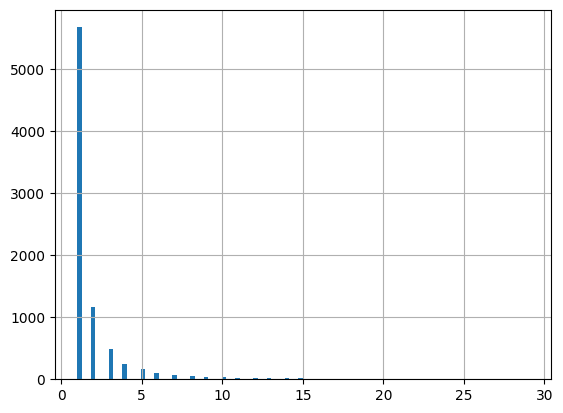

In [ ]:

filtered_series = dest_counts_per_source[(dest_counts_per_source >= 1) & (dest_counts_per_source < 30)]

# Plot the histogram with 1000 bins
filtered_series.hist(bins=100)


In [ ]:
# Assuming dest_counts_per_source is a Series with the count of unique destinations for each source
percentiles = [0.25, 0.5, 0.75, 0.9, 0.99]
percentile_values = dest_counts_per_source.quantile(percentiles)

print("Percentiles for the Number of Unique Destination Nodes per Source Node:")
print(percentile_values)

# Additional insights
mean = dest_counts_per_source.mean()
std_dev = dest_counts_per_source.std()
max_value = dest_counts_per_source.max()
min_value = dest_counts_per_source.min()

print(f"Mean: {mean}, Std Dev: {std_dev}, Max: {max_value}, Min: {min_value}")


Percentiles for the Number of Unique Destination Nodes per Source Node:
0.25     1.0
0.50     1.0
0.75     2.0
0.90     4.0
0.99    16.0
Name: Destination, dtype: float64
Mean: 2.2191564361249543, Std Dev: 7.6189159339091335, Max: 454, Min: 1


#### PRODUCT BASED
- are popular products popular because lots of people are interested or a few are VERY interested? (CDF of unique edges for each product)


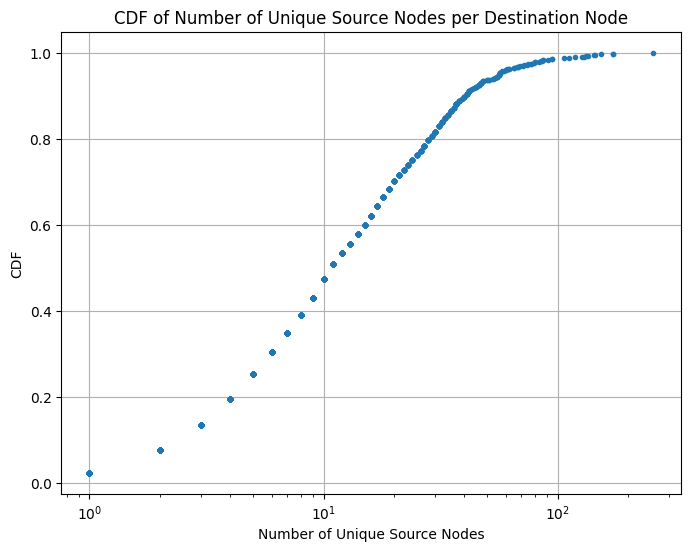

In [ ]:
dest_counts_per_destination = data_df.groupby('Destination')['Source'].nunique()

# Convert the series to a DataFrame for easier manipulation
dest_counts_df = dest_counts_per_destination.reset_index(name='UniqueSourceCount')

plot_cdf(dest_counts_df, 'UniqueSourceCount', log_scale=True, title='CDF of Number of Unique Source Nodes per Destination Node', xlabel='Number of Unique Source Nodes', ylabel='CDF')


<Axes: >

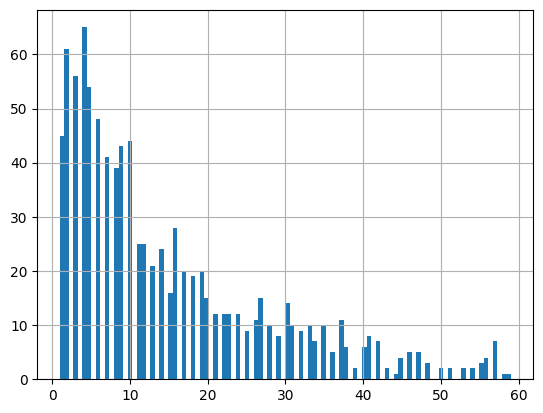

In [ ]:

filtered_series = dest_counts_per_destination[(dest_counts_per_destination >= 1) & (dest_counts_per_destination < 60)]

# Plot the histogram with 100 bins
filtered_series.hist(bins=100)



#### For each user-product interaction
what sort of temporal interactions occur? 

- For each user-product pair, what's the distribution of number of interactions?
Do users repeatedly pick on previous products/pages?


For example do users interact a lot in a short period with one product then drop it, 
or relatively often but for longer period, 
or in periodic (burst of) activity? 

=> CDF of time diff for each source-destination pair
=> Hist of time diff for each source-destination pair 
=> time-destination plot coloured by source 

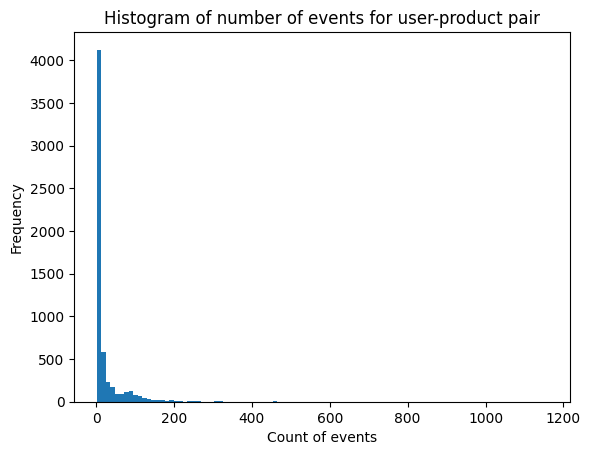

In [ ]:
## DISTRIBUTION OF TIME DIFF averaged over ALL interactions  
data_df['TimeDiff'] = data_df.groupby(['Source', 'Destination'])['Timestamp'].diff().dropna()

periodicity_metrics = data_df.groupby(['Source', 'Destination'])['TimeDiff'].agg(['mean', 'std', 'count']).dropna()
periodicity_metrics.sort_values(by='count', inplace=True)
periodicity_metrics


# Assuming periodicity_metrics is your DataFrame and 'count' is a column in that DataFrame
periodicity_metrics['count'].hist(bins=100)

plt.title('Histogram of number of events for user-product pair')
plt.xlabel('Count of events')
plt.ylabel('Frequency')
plt.grid(False)  # Optionally disable the grid for visual clarity
plt.show()

# MOST Source-destination pairs have <1


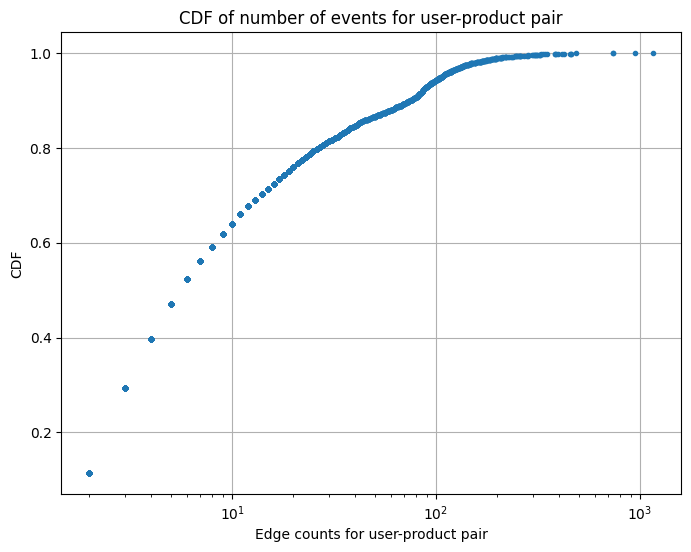

In [ ]:
counts_per_user_product = periodicity_metrics['count']

# Convert the series to a DataFrame for easier manipulation
dest_counts_df = counts_per_user_product.reset_index(name='UserProductCount')

plot_cdf(dest_counts_df, 'UserProductCount', log_scale=True, title='CDF of number of events for user-product pair', xlabel='Edge counts for user-product pair', ylabel='CDF')


In [ ]:
print(counts_per_user_product.mean())
print(counts_per_user_product.median())
print(counts_per_user_product.max())
print(counts_per_user_product.min())


#62% of user-product pair have 10 or less interactions over the full timeframe...
#The average user-product pair has 23 interactions
#the median user-product pair has 5 interactions



23.02313798344874
5.0
1160
2


For each user-product pair, what HOW DO THE INTERACTIONS CHANGE OVER TIME??

-> the TIME DIFF between interactions integrated over the FULL TIME 


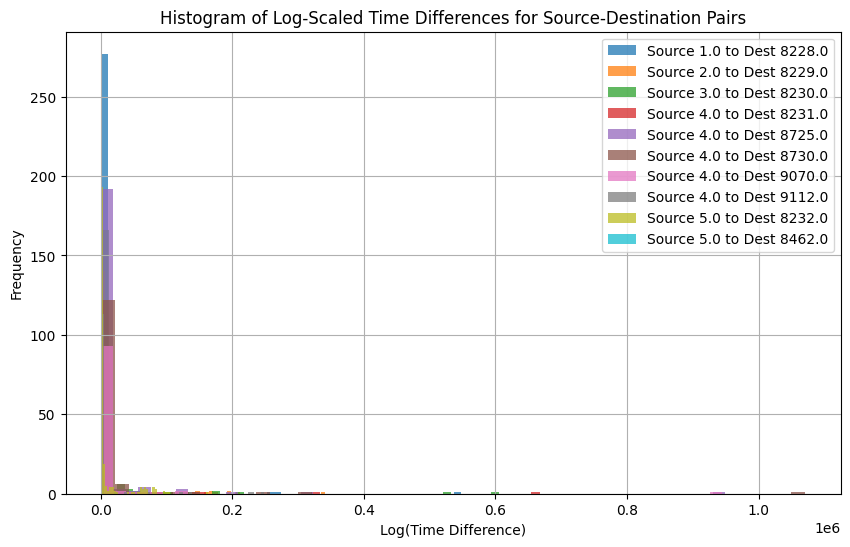

In [ ]:


def plot_histogram_for_source_destination_pairs(data_df, max_pairs=None, bins=50, logscale= True, inc_rand = True):
    """
    Plots the histogram of log-scaled TimeDiff for various source-destination pairs.
    
    Parameters:
    - data_df: DataFrame with 'Source', 'Destination', and 'TimeDiff'.
    - max_pairs: Maximum number of source-destination pairs to plot. If None, plot all pairs.
    - bins: Number of bins for the histogram.
    """
    # Group by source and destination
    grouped = data_df.groupby(['Source', 'Destination'])

    # Prepare the plot
    plt.figure(figsize=(10, 6))

    # Counter to limit the number of pairs plotted if max_pairs is set
    pair_count = 0

    for (source, destination), group in grouped:

        time_diffs = group['TimeDiff'].dropna()
        count = len(time_diffs) + 1
        latest_time = group['Timestamp'][-1:]

        
        # Skip any groups without TimeDiff data
        if 'TimeDiff' not in group or group['TimeDiff'].isnull().all():
            continue

        positive_time_diffs = group['TimeDiff'][group['TimeDiff'] > 0]
        
        if logscale:
            # Filter out non-positive values before log transformation
            
            log_time_diffs = np.log(positive_time_diffs)
            plt.hist(log_time_diffs, bins=bins, label=f'Source {source} to Dest {destination}', alpha=0.75)
        else:
            plt.hist(positive_time_diffs, bins=bins, label=f'Source {source} to Dest {destination}', alpha=0.75)
        
        pair_count += 1
        if max_pairs is not None and pair_count >= max_pairs:
            break

    if inc_rand:
        plt.hist(np.diff(sorted(np.random.uniform(0, int(latest_time), len(time_diffs)))), bins=bins, 
                 label=f'Random', 
                 alpha=0.75)



    plt.xlabel('Log(Time Difference)')
    plt.ylabel('Frequency')
    plt.title('Histogram of Log-Scaled Time Differences for Source-Destination Pairs')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_histogram_for_source_destination_pairs(data_df, max_pairs=10, bins=50, logscale=False)


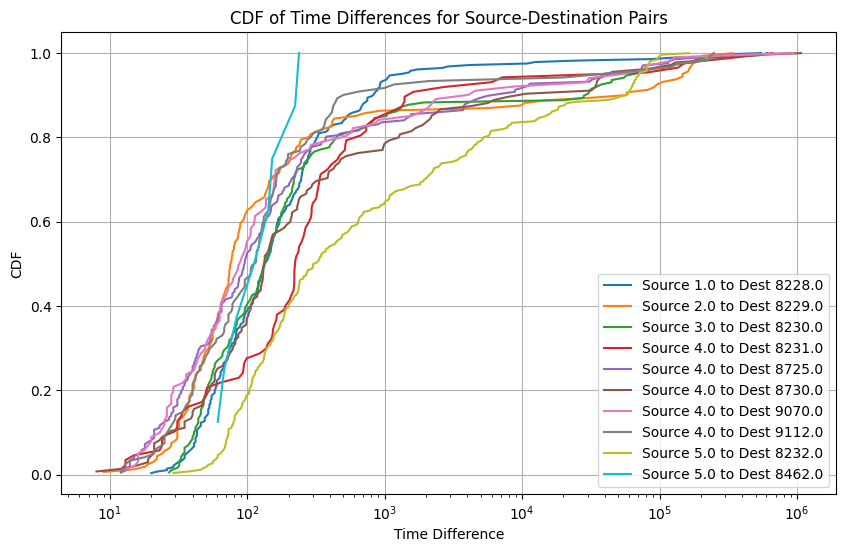

In [ ]:

def plot_cdf_for_source_destination_pairs(data_df, max_pairs=None, log_scale=False):
    """
    Plots the CDF of TimeDiff for various source-destination pairs, with an option for logarithmic x-axis.
    
    Parameters:
    - data_df: DataFrame with 'Source', 'Destination', and 'TimeDiff'.
    - max_pairs: Maximum number of source-destination pairs to plot. If None, plot all pairs.
    - log_scale: Boolean to determine if the x-axis should be on a logarithmic scale. Default is False.
    """
    # Group by source and destination
    grouped = data_df.groupby(['Source', 'Destination'])

    # Prepare the plot
    plt.figure(figsize=(10, 6))

    # Counter to limit the number of pairs plotted if max_pairs is set
    pair_count = 0

    for (source, destination), group in grouped:
        # Skip any groups without TimeDiff data
        if 'TimeDiff' not in group or group['TimeDiff'].isnull().all():
            continue
        
        sorted_time_diffs = np.sort(group['TimeDiff'].dropna().values)
        cdf = np.arange(1, len(sorted_time_diffs) + 1) / len(sorted_time_diffs)

        # Plot
        plt.plot(sorted_time_diffs, cdf, label=f'Source {source} to Dest {destination}')
        
        pair_count += 1
        if max_pairs is not None and pair_count >= max_pairs:
            break

    if log_scale:
        plt.xscale('log')  # Set the x-axis to a logarithmic scale

    plt.xlabel('Time Difference')
    plt.ylabel('CDF')
    plt.title('CDF of Time Differences for Source-Destination Pairs')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
plot_cdf_for_source_destination_pairs(data_df, max_pairs=10, log_scale=True)


/var/folders/53/d8br5nln6vq67q925j2wx6kc0000gn/T/ipykernel_28655/1255582204.py:46: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


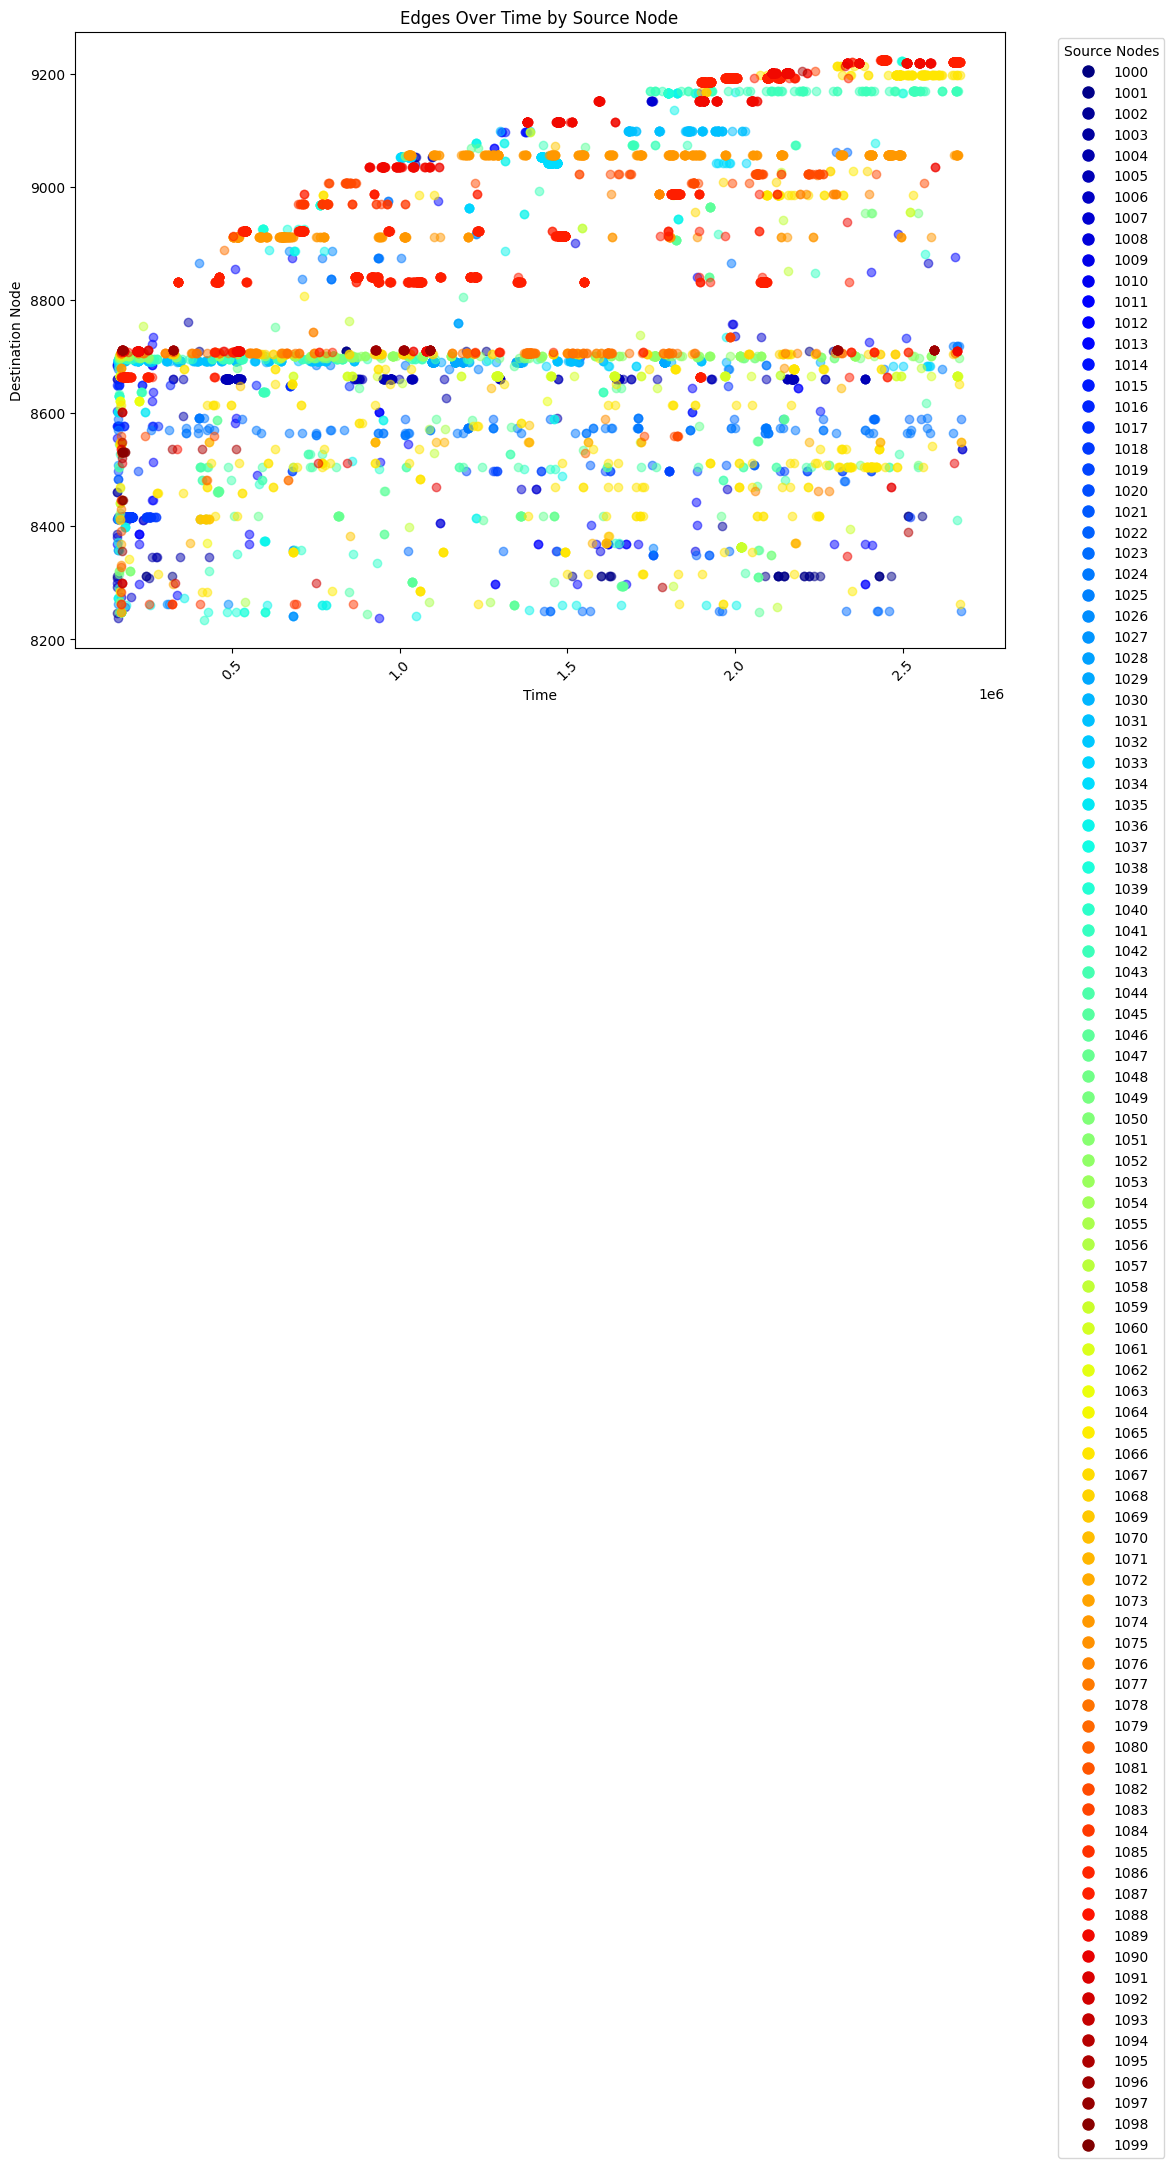

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_edges_over_time_by_source(data_df, source_subset):
    """
    Plots edges over time for a specified subset of source nodes.

    Parameters:
    - data_df: DataFrame containing the columns 'Source', 'Destination', and 'Timestamp'.
    - source_subset: Array-like, the subset of source nodes to include in the plot.
    """
    # Filter the DataFrame for the specified source nodes
    filtered_data = data_df[data_df['Source'].isin(source_subset)].copy()

    # Ensure Timestamp is in datetime format if not already
    # filtered_data['Timestamp'] = pd.to_datetime(filtered_data['Timestamp'])

    # Sort data by timestamp
    filtered_data.sort_values(by='Timestamp', inplace=True)

    # Create a figure and axis for the plot
    fig, ax = plt.subplots(figsize=(12, 8))

    # Generate a color for each source node in the filtered subset
    colors = plt.cm.jet(np.linspace(0, 1, len(source_subset)))

    # Map each source node to a color
    color_map = {source: color for source, color in zip(source_subset, colors)}

    # Plot each edge, coloring by source node
    for (source, destination), group in filtered_data.groupby(['Source', 'Destination']):
        ax.scatter(group['Timestamp'], [destination] * len(group), color=color_map[source], label=source, alpha=0.5)

    # Create a custom legend
    legend_elements = [Line2D([0], [0], marker='o', color='w', label=source,
                              markerfacecolor=color, markersize=10)
                       for source, color in color_map.items()]
    ax.legend(handles=legend_elements, title="Source Nodes", bbox_to_anchor=(1.05, 1), loc='upper left')

    # Improve readability of the plot
    ax.set_xlabel('Time')
    ax.set_ylabel('Destination Node')
    ax.set_title('Edges Over Time by Source Node')
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Show the plot
    plt.show()

# Example usage
# Assuming 'data_df' is your DataFrame and 'source_subset' is defined
    
source_subset = np.arange(1000, 1100, 1)
plot_edges_over_time_by_source(data_df, source_subset)


In [ ]:


# Total Variation Distance function
def total_variation_distance(p, q):
    return 0.5 * np.sum(np.abs(p - q))

# Hellinger Distance function
def hellinger_distance(p, q):
    return np.sqrt(0.5 * np.sum((np.sqrt(p) - np.sqrt(q))**2))

def compute_distances(data_df):
    # Group by source and destination
    grouped = data_df.groupby(['Source', 'Destination'])
    
    results = []

    for (source, destination), group in grouped:
        time_diffs = group['TimeDiff'].dropna()
        count = len(time_diffs) + 1
        latest_time = group['Timestamp'][-1:]
        
        # Skip if the group is empty
        if time_diffs.empty:
            continue
        
        bins = int(len(time_diffs))

        # Calculate histogram of the time differences
        counts_p, _ = np.histogram(time_diffs, bins=bins, density=True)
        p = counts_p/sum(counts_p)

        #check metrics as random vs random
        #counts_p, _= np.histogram(np.diff(sorted(np.random.uniform(0, int(latest_time), len(time_diffs)))), bins=bins)
        #p = counts_p/sum(counts_p)

        
        # Generate a random sequence and its histogram of time diff
        counts_q, _ = np.histogram(np.diff(sorted(np.random.uniform(0, int(latest_time), len(time_diffs)))), bins=bins)
        q = counts_q / sum(counts_q)  # Normalize to probabilities

        
        # Compute distances
        tv_distance = total_variation_distance(p, q)
        hellinger = hellinger_distance(p, q)
        
        results.append({
            'Source': source,
            'Destination': destination,
            'Count': count,
            'Total Variation Distance': tv_distance,
            'Hellinger Distance': hellinger
        })
    
    results_df = pd.DataFrame(results)

    return results_df


In [ ]:
# Example usage
results_df = compute_distances(data_df)


/var/folders/53/d8br5nln6vq67q925j2wx6kc0000gn/T/ipykernel_91743/4046941313.py:37: RuntimeWarning: invalid value encountered in divide
  q = counts_q / sum(counts_q)  # Normalize to probabilities


In [ ]:
results_df = results_df[results_df['Count'] >100]


In [ ]:
results_df

,Source,Destination,Count,Total Variation Distance,Hellinger Distance
0,1.0,8228.0,285,0.929465,0.871775
1,2.0,8229.0,162,0.894216,0.866587
2,3.0,8230.0,189,0.850808,0.803173
4,4.0,8725.0,208,0.850054,0.805089
5,4.0,8730.0,136,0.829132,0.777313
...,...,...,...,...,...
8203,6768.0,9191.0,148,0.767822,0.736536
8217,6790.0,8861.0,109,0.814036,0.804941
8251,6862.0,9196.0,198,0.791257,0.762739
8549,7522.0,9213.0,127,0.864571,0.823088


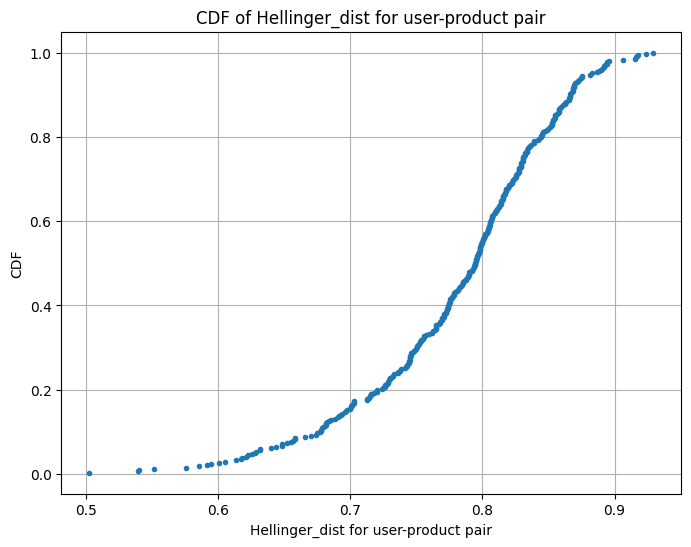

In [ ]:

Hellinger_dist = results_df['Hellinger Distance']

# Convert the series to a DataFrame for easier manipulation
dest_counts_df = Hellinger_dist.reset_index(name='Hellinger_dist')

plot_cdf(dest_counts_df, 'Hellinger_dist', log_scale=False, title='CDF of Hellinger_dist for user-product pair', xlabel='Hellinger_dist for user-product pair', ylabel='CDF')


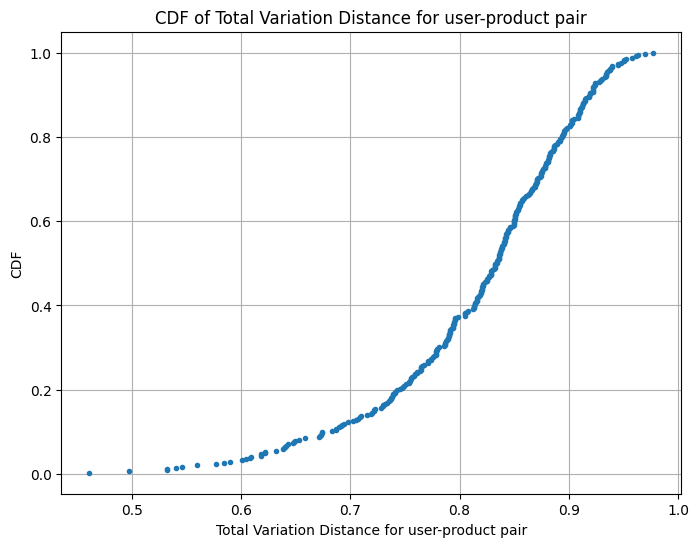

In [ ]:



Total_Variation_Distance = results_df['Total Variation Distance']

# Convert the series to a DataFrame for easier manipulation
dest_counts_df = Total_Variation_Distance.reset_index(name='Total Variation Distance')

plot_cdf(dest_counts_df, 'Total Variation Distance', log_scale=False, title='CDF of Total Variation Distance for user-product pair', xlabel='Total Variation Distance for user-product pair', ylabel='CDF')


In [ ]:


filtered_results_df = results_df[results_df['Total Variation Distance'] >0.9]
source_subset = filtered_results_df['Source'].unique()

plot_edges_over_time_by_source(data_df, source_subset)


NameError: name 'plot_edges_over_time_by_source' is not defined

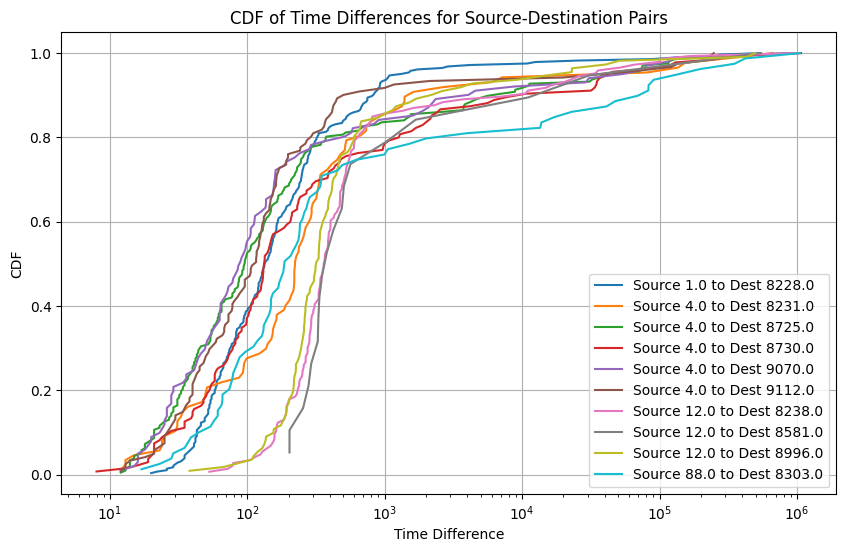

In [ ]:

filtered_data_df = data_df[data_df['Source'].isin(source_subset)]

# Now call the plot_cdf_for_source_destination_pairs function with the filtered DataFrame
plot_cdf_for_source_destination_pairs(filtered_data_df, max_pairs=10, log_scale=True)

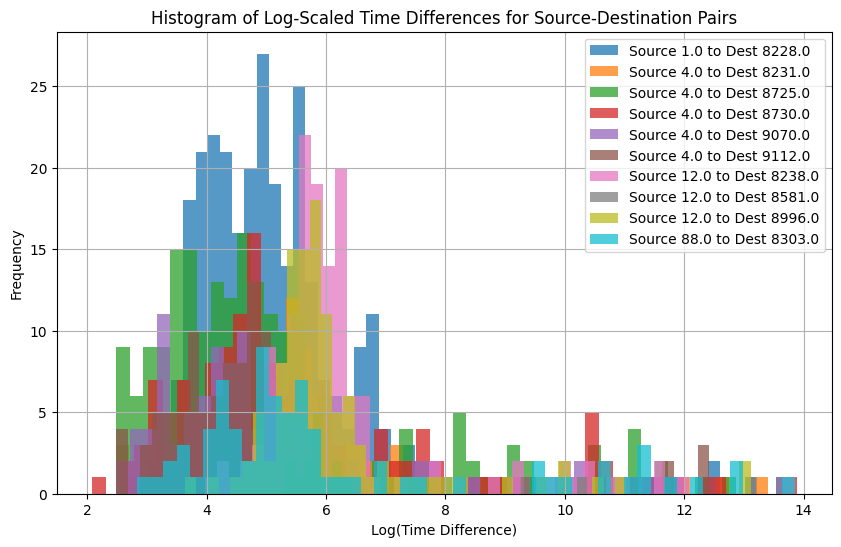

In [ ]:
plot_histogram_for_source_destination_pairs_log_scale(filtered_data_df, max_pairs=10, bins=50)


In [ ]:


def plot_histogram_with_random_sequence(data_df, max_pairs=None, bins=50, log_scale=False, include_random=False):
    """
    Plots the histogram of TimeDiff for various source-destination pairs, with optional log scaling and random sequence comparison.
    
    Parameters:
    - data_df: DataFrame with 'Source', 'Destination', and 'TimeDiff'.
    - max_pairs: Maximum number of source-destination pairs to plot. If None, plot all pairs.
    - bins: Number of bins for the histogram.
    - log_scale: Boolean, applies a logarithmic scale to the x-axis if True.
    - include_random: Boolean, includes a histogram of a random uniform sequence if True.
    """
    grouped = data_df.groupby(['Source', 'Destination'])
    plt.figure(figsize=(10, 6))
    pair_count = 0

    for (source, destination), group in grouped:
        if 'TimeDiff' not in group or group['TimeDiff'].isnull().all():
            continue
        
        time_diffs = group['TimeDiff'].dropna()
        
        if include_random:
            random_seq = sorted(np.random.uniform(low=time_diffs.min(), high=time_diffs.max(), size=len(time_diffs)))

            plt.hist(np.diff(random_seq), bins=bins, color='black', alpha=0.5, label='Random Uniform' if pair_count == 0 else "", density=True)

        plt.hist(time_diffs, bins=bins, alpha=0.75, label=f'Source {source} to Dest {destination}', density=True)
        
        pair_count += 1
        if max_pairs is not None and pair_count >= max_pairs:
            break

    if log_scale:
        plt.xscale('log')

    plt.xlabel('Time Difference')
    plt.ylabel('Frequency')
    plt.title('Histogram of Time Differences for Source-Destination Pairs')
    plt.legend()
    plt.grid(True)
    plt.show()


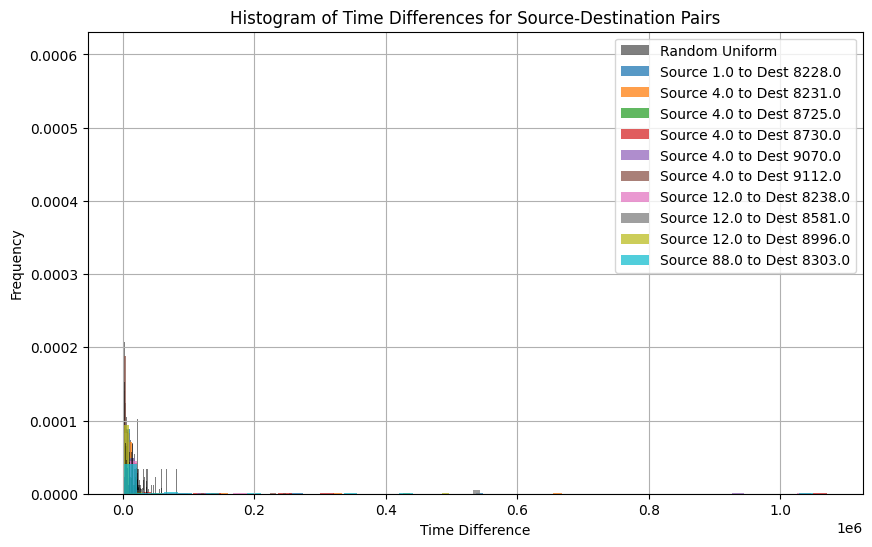

In [ ]:
plot_histogram_with_random_sequence(filtered_data_df,max_pairs=10, bins=50, log_scale=False, include_random=True)

### Download the TGL datasets

In [ ]:
data_urls = DATA_URL_DICT
data_urls

{'tgbl-wiki': 'https://object-arbutus.cloud.computecanada.ca/tgb/tgbl-wiki-v2.zip',
 'tgbl-review': 'https://object-arbutus.cloud.computecanada.ca/tgb/tgbl-review-v2.zip',
 'tgbl-coin': 'https://object-arbutus.cloud.computecanada.ca/tgb/tgbl-coin-v2.zip',
 'tgbl-flight': 'https://object-arbutus.cloud.computecanada.ca/tgb/tgbl-flight-v2.zip',
 'tgbl-comment': 'https://object-arbutus.cloud.computecanada.ca/tgb/tgbl-comment.zip',
 'tgbn-trade': 'https://object-arbutus.cloud.computecanada.ca/tgb/tgbn-trade.zip',
 'tgbn-genre': 'https://object-arbutus.cloud.computecanada.ca/tgb/tgbn-genre.zip',
 'tgbn-reddit': 'https://object-arbutus.cloud.computecanada.ca/tgb/tgbn-reddit.zip',
 'tgbn-token': 'https://object-arbutus.cloud.computecanada.ca/tgb/tgbn-token.zip'}

In [ ]:
import os
import requests
import zipfile

def download_and_unzip(url, extract_to='.'):
    """
    Download a ZIP file from a specified URL and extract its contents to a specified directory
    only if the ZIP file hasn't been extracted there before.
    
    Parameters:
    - url: The URL of the ZIP file to download.
    - extract_to: The directory to extract the contents of the ZIP file. Defaults to the current directory.
    """
    # Ensure the extract_to directory exists
    os.makedirs(extract_to, exist_ok=True)

    # Get the name of the file
    filename = url.split('/')[-1]
    zip_path = os.path.join(extract_to, filename)

    # Check if the file or directory already exists to avoid re-downloading and re-extracting
    if os.path.exists(zip_path):  # You might need a more robust check here
        print(f"{filename} already exists in {extract_to}. Skipping download and extraction.")
        return

    # Download the file
    print(f"Downloading {filename}...")
    response = requests.get(url)
    response.raise_for_status()  # Check if the download was successful

    # Save the file to the current directory
    with open(zip_path, 'wb') as zip_file:
        zip_file.write(response.content)
    print(f"Downloaded {filename}.")

    # Unzip the file
    print(f"Extracting {filename}...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"Extracted {filename} to {extract_to}.")

    # Optionally, remove the ZIP file after extraction
    os.remove(zip_path)
    print(f"Removed {filename}.")

# Example usage
# url = "https://example.com/path/to/your/zipfile.zip"
# download_and_unzip(url, 'path/to/extract/directory')


In [ ]:
for _, link in data_urls.items():
    download_and_unzip(link, './GDL_project_HQ/Data')
    #pass

KeyboardInterrupt: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_cdf_np(data):
    """
    Plots the Cumulative Distribution Function (CDF) for the given dataset.

    Parameters:
    - data: An array-like sequence of data points.
    """
    # Sort the data
    sorted_data = np.sort(data)
    
    # Compute the CDF values
    cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    
    # Plotting the CDF
    plt.figure(figsize=(10, 6))
    plt.plot(sorted_data, cdf, marker='.', linestyle='none')
    plt.title('Cumulative Distribution Function (CDF) of the Data')
    plt.xlabel('Data value')
    plt.ylabel('CDF value')
    plt.grid(True)
    plt.show()


### Metrics for periodic time series 

In this section I am trying to come up with an edge based metric for periodicity. 

Methods like the Fourier transform are useful when there is both a timestamp and a value associated with it: imagine a superimposed combinatino of different frequency waves which can be decomposed into their basis frequencies. 

However, it does not work well for just timestamps without any values, which is the kind of data we are likely to get.
In reality even if the data has values associated with it, like in the Wiki dataset, they are vectors for words which seems like converting to a real number between -1 and 1 isn't that meaningful. 


#### Generating data

To test the periodicity we need examples that get progressively more difficult. 
To make it increasingly difficult I look at 3 variables: number of 'channels', and noise. 

Noise:
- uniform distribution that can alter the exact value of a specific timepoint within a certain window
- can also pick normal distribution as easier noise

Channels
- regular 1 channel, 0 noise: i.e. 0,3,6,9,12, ... 
- regular 1 channel, small gaussian noise i.e. 0.1, 3.2, 5.8, 8.9, 12.2
- regular 1 channel, small uniform noise 

- 2 channels, 0 noise:
    first channel: multiples of 3, 
    second channel: multiples of 7
    total: 0,3, 6, 7, 9, 12, 14, 15, ... 



In [ ]:
def generate_arithmetic_seq(gaps:list, 
                            noise_var:int, 
                            total_points:int):
    # gaps: the arithmetic summation gap for each channel
    # noise_var: the integer value describing the max +/- range that is used for uniform distribution 
    # total_points: how long the final sequence needs to be 
    # return: the sequence, sorted and filtered to specific length 
    
    sequences = []
    for c in range(len(gaps)):
        if c==0:
            sequences.append([(0+i*gaps[c])+np.random.uniform(-noise_var, noise_var) for i in range(total_points)])
        else:
            max_value= sequences[0][-1]
            #print(sequences[0][-1])
            new_total_points = int(max_value/gaps[c])
            sequences.append([(0+i*gaps[c])+np.random.uniform(-noise_var, noise_var) for i in range(new_total_points)])

    sequences = list(itertools.chain.from_iterable(sequences))
    sequences = sorted(sequences)[:total_points]

    return(sequences)
        

In [ ]:
random_seq = sorted(np.random.uniform(0, 1000, 1000))

In [ ]:
seq = generate_arithmetic_seq([5], 5, 100)


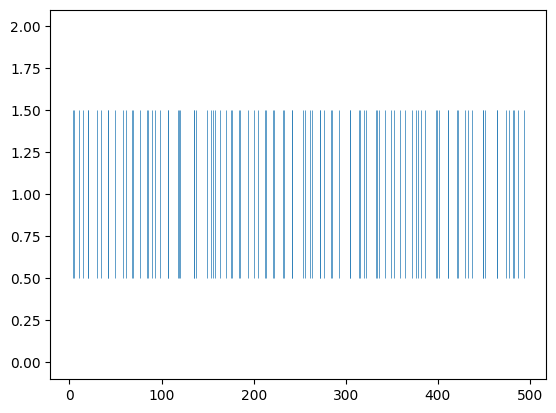

In [ ]:
plt.eventplot(seq, linewidths=0.5)

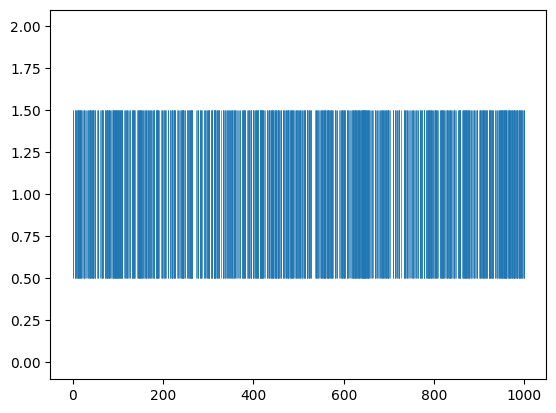

In [ ]:
plt.eventplot(random_seq, linewidths=0.5)

#### Metrics for periodicity

Ok this is the first hard bit...

if we have a rhyhthm, how do we think quantifying its periodicity?

on one extreme we have random/white noise, where no event can tell us about the sequence
on the other we have something extremely regular, where after 2 or 3 or 4 we could have a good guess of continuing correctly

The idea of entropy or surprise comes to mind: given we have 3 points, how surprised would we be about the 4th?

I don't have much clue about how to think about this from an information theory perspective... would need help!


Starting simple however:

1) Take the diffrence of the points. 
- The difference of a completely random distribution should at its limit go towards a gaussian as per central limit theorm. The gaussian will bound to be positive. 
- The difference within a noiseless series should be very high at specific peak
- if there is a small amount of noise around each peak this suggests some minor noise 
=> this last bit reminds of maybe signal to noise quantification. If we have a 0 noise periodic pattern, the signal to noise should be very high and lower otherwise. 


2) OR could try to see how SIMILAR the distribution of a completely random one is to a non-random!! with a KL divergence?? or a wasserstein distance?




In [ ]:
sample_sequences = {'random': random_seq,
             'single_no_noise': generate_arithmetic_seq([3], 0, 100),
             'single_noise': generate_arithmetic_seq([3], 0.1, 100),
             'double_no_noise': generate_arithmetic_seq([3,8], 0, 100),
             'double_noise': generate_arithmetic_seq([3,8], 0.1, 100),
             'double_med_noise': generate_arithmetic_seq([3,8], 1, 100),
             'double_large_noise': generate_arithmetic_seq([3,8], 10, 100)

}

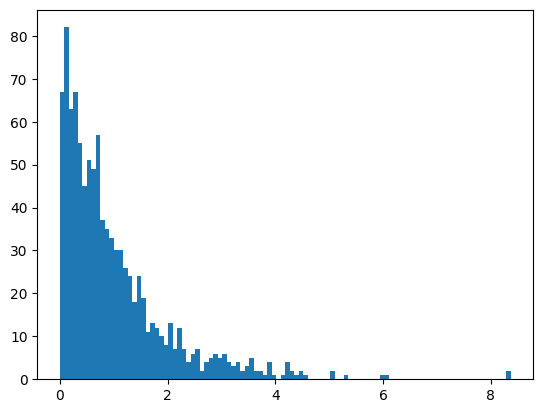

In [ ]:
res = plt.hist(np.diff(random_seq), bins=len(seq))


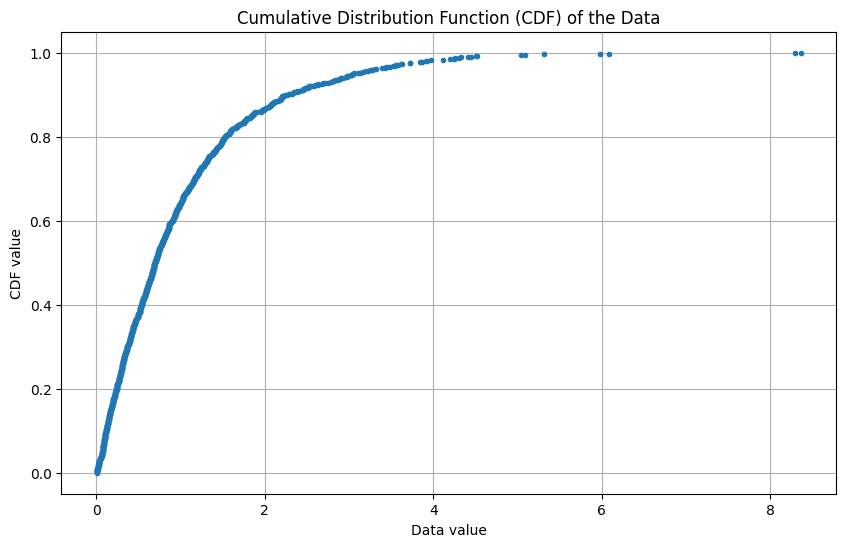

In [ ]:
plot_cdf_np(np.diff(random_seq))

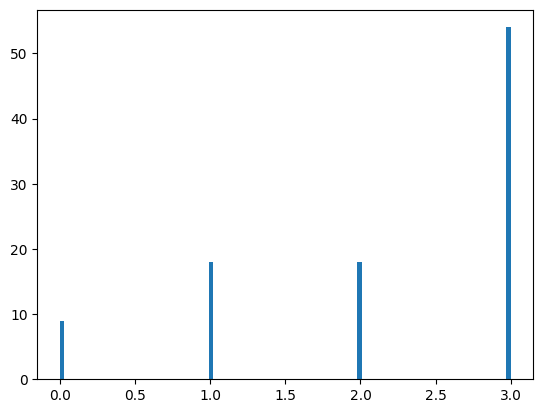

In [ ]:
seq = generate_arithmetic_seq([3,8], 0, 100)
res = plt.hist(np.diff(seq), bins=len(seq))


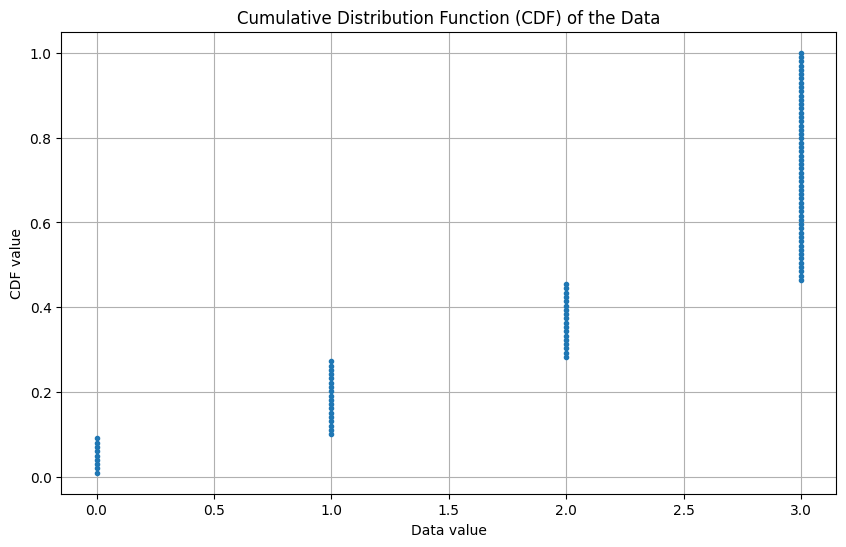

In [ ]:
plot_cdf_np(np.diff(seq))

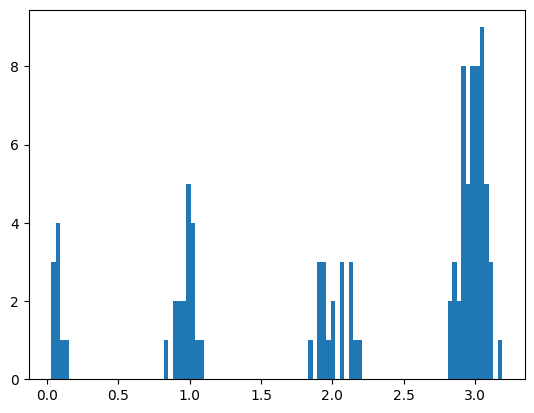

In [ ]:
seq = generate_arithmetic_seq([3,8], 0.1, 100)
res = plt.hist(np.diff(seq), bins=len(seq))


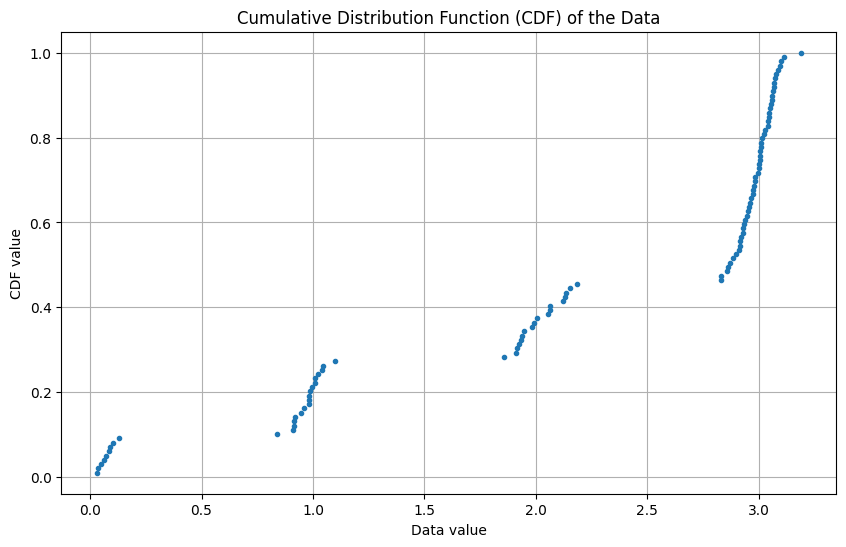

In [ ]:
plot_cdf_np(np.diff(seq))

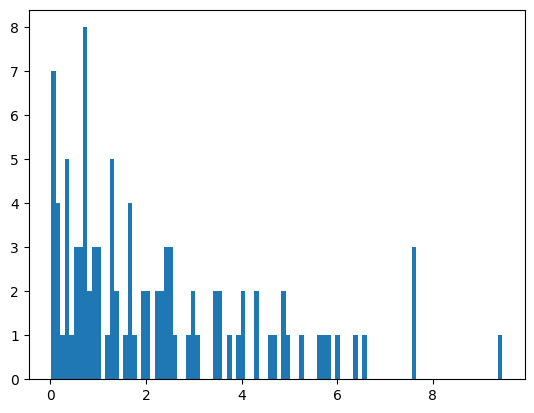

In [ ]:
seq = generate_arithmetic_seq([3,8], 10, 100)
res = plt.hist(np.diff(seq), bins=len(seq))


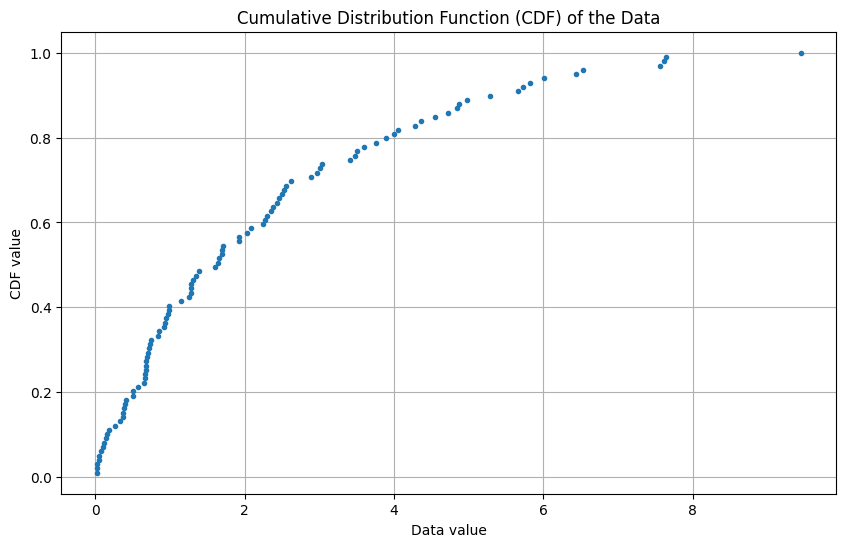

In [ ]:
plot_cdf_np(np.diff(seq))

**Simple metrics from difference**

We can start by comparing the variance of the differences amongst the values.. 

In [ ]:
def seq_diff_variance (sequence):
    # Calculate differences between consecutive numbers
    differences = np.diff(sequence)
    
    # Calculate the variance of these differences
    variance_of_differences = np.var(differences)
    
    # The higher the variance, the higher the 'entropy'
    return variance_of_differences
# Example sequence with regular intervals


In [ ]:
for key, value in sample_sequences.items():
    print(f'{key}: {seq_diff_variance(value)}')

random: 1.1683608409392499
single_no_noise: 0.0
single_noise: 0.0071972791439991425
double_no_noise: 1.0578512396694213
double_noise: 1.0512413610676197
double_med_noise: 1.3220273231828985
double_large_noise: 4.307135735242676


That does not work very well..

How about we try the distance between the random diff distribution and each one? 

In [ ]:
# Example of computing distances between two discrete distributions p and q
def kl_divergence(p, q):
    """Compute KL Divergence between two distributions."""
    return np.sum(rel_entr(p, q))

def js_divergence(p, q):
    """Symmetric measure, derived from KL Divergence."""
    m = 0.5 * (p + q)
    return 0.5 * kl_divergence(p, m) + 0.5 * kl_divergence(q, m)

def js_distance(p, q):
    return np.sqrt(js_divergence(p, q))

# Total Variation Distance
def total_variation_distance(p, q):
    return 0.5 * np.sum(np.abs(p - q))

# Hellinger Distance
def hellinger_distance(p, q):
    return np.sqrt(0.5 * np.sum((np.sqrt(p) - np.sqrt(q))**2))

# Wasserstein Distance (Earth Mover’s Distance)
def wasserstein_distance_wrapper(p, q, bins_p, bins_q):
    # Calculate the midpoints of the bins for both distributions
    midpoints_p = 0.5 * (bins_p[:-1] + bins_p[1:])
    midpoints_q = 0.5 * (bins_q[:-1] + bins_q[1:])
    
    # Use the counts as weights for the Wasserstein distance
    return wasserstein_distance(midpoints_p, midpoints_q, p, q)




In [ ]:
methods = [
    kl_divergence,
    js_divergence,
    js_distance,
    total_variation_distance,
    hellinger_distance,
    wasserstein_distance_wrapper
]

# Correct DataFrame initialization using method objects
df = pd.DataFrame(index=[method.__name__ for method in methods], columns=sample_sequences.keys())

# Reference distribution p calculation
counts_p, bins_p = np.histogram(np.diff(sorted(np.random.uniform(0, 100, 100))), bins=len(random_seq))
p = counts_p / sum(counts_p)  # Normalize to probabilities

# Iterate through sequences and methods
for k, v in sample_sequences.items():
    counts_v, bins_v = np.histogram(np.diff(v), bins=len(v))
    q = counts_v / sum(counts_v)  # Normalize to probabilities

    for method in methods:
        # Special handling for wasserstein_distance_wrapper due to additional arguments
        if method.__name__ == 'wasserstein_distance_wrapper':
            try:
                result = method(p, q, bins_p, bins_v)
            except ValueError as e:
                result = np.nan  # Handle incompatible dimensions
        else:
            try:
                result = method(p, q)
            except ValueError as e:
                result = np.nan  # Handle incompatible dimensions
        
        df.loc[method.__name__, k] = result



In [ ]:
df

,random,single_no_noise,single_noise,double_no_noise,double_noise,double_med_noise,double_large_noise
kl_divergence,inf,inf,inf,inf,inf,inf,inf
js_divergence,0.243532,0.693147,0.394988,0.621777,0.494407,0.342383,0.247182
js_distance,0.493489,0.832555,0.62848,0.788528,0.703141,0.585135,0.497174
total_variation_distance,0.494949,1.0,0.666667,0.959596,0.777778,0.59596,0.484848
hellinger_distance,0.573649,1.0,0.743583,0.91655,0.838416,0.691762,0.580676
wasserstein_distance_wrapper,0.196905,2.053457,2.03799,1.239105,1.227551,1.175657,1.190734


TOTAL_VARIATION_DISTANCE ad Hellinger distance both seem good options.
now we need to validate these and try them over a varying set of sequences

1) do they give the same value regardless of where the 'diff' is?
2) what if the top diff value is huge or very small?


We also haven't really looked at metrics such as:
- **Gap size** (what proportion of edges have gaps that are v close vs far away)
- **Continuous vs intermittent**
- **Clusters or not**

for example, the interaction could be clusters of 10 or so, then large gap, then cluster again 


**This way we can split node-node interactions by the TYPE of temporal edge recurrence they have!**

1) we need to adjust the data generation function to start having a look at these other patterns.
2) come up with metrics for each of these






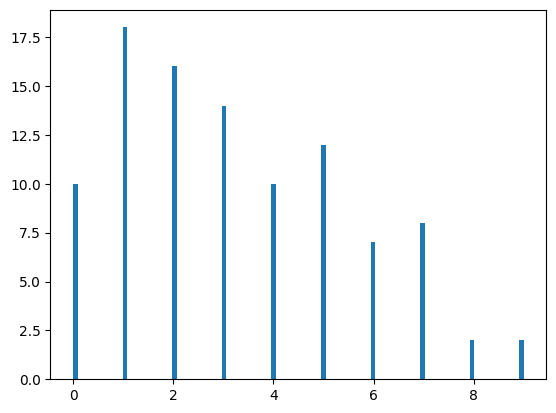

In [ ]:
seq = generate_arithmetic_seq([9,10,11], 0, 100)
#plt.eventplot(seq)
res = plt.hist(np.diff(seq), bins=len(seq))


## Inference and generation

The metrics above give an overall sense if a timeseries is random or regular, but do not give further indication on the regularity.
For example:
- what IS the pattern? and the noise associated with it?


Ultimately the generative aim is to be able to infer from the timeseries data what is going to happen next!
One way to do this is to do a Maximum Likelihood on the data generating parameters i.e. one vs multi channel, gap, noise...
A fully bayesian method would also give a prior on sequences and therefore a full posterior distribution on the parameters.

Once inference is achieved, the model can continue the sequence (and do link prediction) with minimal errors. 
This is ultimately what we want our GNN model to do: 
- as a sequence is starting, come up with possible latents (that may themselves move over time) that describe the sequence generating function 
- this function needs to take into account the previous data, and the one/multi hop interactions of that node with other edges. 
    For example, a BURST of edges at a between multiplen nodes that can be predicted by the interaction between neighbouring nodes just preceding it


This allows for each node-node to have 





In [ ]:
def generate_arithmetic_seq(gaps, noise_var, total_points):
    
    sequences = []
    for c in range(len(gaps)):
        if c==0:
            sequences.append([(0+i*gaps[c])+np.random.uniform(-noise_var, noise_var) for i in range(total_points)])
        else:
            max_value= sequences[0][-1]
            #print(sequences[0][-1])
            new_total_points = int(max_value/gaps[c])
            sequences.append([(0+i*gaps[c])+np.random.uniform(-noise_var, noise_var) for i in range(new_total_points)])

    sequences = list(itertools.chain.from_iterable(sequences))
    sequences = sorted(sequences)[:total_points]

    return(sequences)
        

In [ ]:

def generate_combinations(elements):
    all_combinations = []
    for r in range(1, len(elements) + 1):
        # Generate and append combinations of length r
        all_combinations.extend([list(comb) for comb in combinations(elements, r)])
    return all_combinations

elements = range(10)
combinations_output = generate_combinations(elements)
combinations_output

total_data = []

for i in combinations_output:
    for j in range(20):
        total_data.append(generate_arithmetic_seq(i, 0, 100))

In [ ]:
len(total_data)

20460

In [ ]:
total_data[0]

[0.0,
 0.0,
 0.0,
 2.0,
 4.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 12.0,
 14.0,
 14.0,
 16.0,
 18.0,
 18.0,
 20.0,
 21.0,
 22.0,
 24.0,
 26.0,
 27.0,
 28.0,
 28.0,
 30.0,
 32.0,
 34.0,
 35.0,
 36.0,
 36.0,
 38.0,
 40.0,
 42.0,
 42.0,
 44.0,
 45.0,
 46.0,
 48.0,
 49.0,
 50.0,
 52.0,
 54.0,
 54.0,
 56.0,
 56.0,
 58.0,
 60.0,
 62.0,
 63.0,
 63.0,
 64.0,
 66.0,
 68.0,
 70.0,
 70.0,
 72.0,
 72.0,
 74.0,
 76.0,
 77.0,
 78.0,
 80.0,
 81.0,
 82.0,
 84.0,
 84.0,
 86.0,
 88.0,
 90.0,
 90.0,
 91.0,
 92.0,
 94.0,
 96.0,
 98.0,
 98.0,
 99.0,
 100.0,
 102.0,
 104.0,
 105.0,
 106.0,
 108.0,
 108.0,
 110.0,
 112.0,
 112.0,
 114.0,
 116.0,
 117.0,
 118.0,
 119.0,
 120.0,
 122.0,
 124.0,
 126.0,
 126.0,
 126.0,
 128.0,
 130.0]

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class ImprovedSequenceModel(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, activation_fn=F.relu, dropout_rate=0.5):
        super(ImprovedSequenceModel, self).__init__()
        
        self.activation_fn = activation_fn
        
        # Dynamically create hidden layers
        self.hidden_layers = nn.ModuleList()
        prev_size = input_size
        for hidden_size in hidden_sizes:
            self.hidden_layers.append(nn.Linear(prev_size, hidden_size))
            self.hidden_layers.append(nn.BatchNorm1d(hidden_size))
            self.hidden_layers.append(nn.Dropout(dropout_rate))
            prev_size = hidden_size
        
        self.output_layer = nn.Linear(prev_size, output_size)
        
    def forward(self, x):
        for layer in self.hidden_layers:
            if isinstance(layer, nn.Linear):
                x = self.activation_fn(layer(x))
            else:
                x = layer(x)
        x = self.output_layer(x)
        return x

# Model instantiation
input_size = 70  # Input sequence length
hidden_size = [64]  # Hidden layers size
output_size = 30  # Output sequence length (continuation)

model = ImprovedSequenceModel(input_size, hidden_size, output_size)

# Check if a GPU is available and move the model to GPU if it is
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(model)


ImprovedSequenceModel(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=70, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.5, inplace=False)
  )
  (output_layer): Linear(in_features=64, out_features=30, bias=True)
)


In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer, TransformerDecoder, TransformerDecoderLayer

class TransformerSequenceModel(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, nhead=6, num_layers=2, dropout=0.2):
        super(TransformerSequenceModel, self).__init__()
        
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        
        # Transformer encoder layers
        encoder_layers = TransformerEncoderLayer(d_model=input_size, nhead=nhead, dropout=dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, num_layers=num_layers)
        
        # Transformer decoder layers
        decoder_layers = TransformerDecoderLayer(d_model=input_size, nhead=nhead, dropout=dropout)
        self.transformer_decoder = TransformerDecoder(decoder_layers, num_layers=num_layers)
        
        # Fully connected output layer
        self.fc_output = nn.Linear(input_size, output_size)
        
    def forward(self, x):
        # Transformer encoder
        encoder_output = self.transformer_encoder(x)
        
        # Transformer decoder (use encoder_output as memory)
        decoder_output = self.transformer_decoder(x, encoder_output)
        
        # Fully connected output layer
        x = self.fc_output(decoder_output[:, -1, :])  # Take the output of the last time step
        return x

    

# Model instantiation
input_size = 70  # Input sequence length
hidden_size = 64  # Hidden layers size
output_size = 30  # Output sequence length (continuation)

model = TransformerSequenceModel(input_size, hidden_size, output_size)

# Check if a GPU is available and move the model to GPU if it is
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(model)


AssertionError: embed_dim must be divisible by num_heads

In [ ]:
# Mock data preparation for demonstration
import random
import torch

# Assuming total_data is a list of lists where each inner list represents a sequence

# Parameters for mock dataset
num_samples = len(total_data)  # Number of samples in the dataset
sequence_length = input_size  # Length of each input sequence
continuation_length = output_size  # Length of each sequence continuation (target)

# Generate mock data
random.seed(0)  # For reproducibility
random.shuffle(total_data)  # Shuffle the data

# Extract input and target sequences
inputs = torch.tensor([seq[:sequence_length] for seq in total_data], dtype=torch.float32)
targets = torch.tensor([seq[sequence_length:sequence_length + continuation_length] for seq in total_data], dtype=torch.float32)

# Split the dataset into training, validation, and test sets
train_size = int(num_samples * 0.7)
val_size = int(num_samples * 0.2)
test_size = num_samples - train_size - val_size

train_dataset = torch.utils.data.TensorDataset(inputs[:train_size], targets[:train_size])
val_dataset = torch.utils.data.TensorDataset(inputs[train_size:train_size + val_size], targets[train_size:train_size + val_size])
test_dataset = torch.utils.data.TensorDataset(inputs[train_size + val_size:], targets[train_size + val_size:])

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)


In [ ]:

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop (simplified for demonstration)
epochs = 100
model.train()  # Set model to training mode

for epoch in range(epochs):
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)  # Move data to the appropriate device
        
        optimizer.zero_grad()  # Zero the parameter gradients
        #print(inputs)
        outputs = model(inputs)  # Forward pass
        #print(outputs)
        #print(targets)
        loss = criterion(outputs, targets)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights
        
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}")

# Note: This is a simplified example. Proper training would include validation checks, saving the model, etc.


Epoch 1, Loss: 3002.3829197628156
Epoch 2, Loss: 2981.1547370808466
Epoch 3, Loss: 2959.259830440794
Epoch 4, Loss: 2968.2493321384704
Epoch 5, Loss: 2972.9495778765
Epoch 6, Loss: 2977.5738226345607
Epoch 7, Loss: 2975.2912963543617
Epoch 8, Loss: 2964.2260911294393
Epoch 9, Loss: 2962.951973267964
Epoch 10, Loss: 2975.6566598415375
Epoch 11, Loss: 2952.368497303554
Epoch 12, Loss: 2982.6749070116452
Epoch 13, Loss: 2959.7568729604995
Epoch 14, Loss: 3001.1800299371994
Epoch 15, Loss: 2941.9159529379435
Epoch 16, Loss: 2975.356298310416
Epoch 17, Loss: 2956.3104259627207
Epoch 18, Loss: 2956.4395711592265
Epoch 19, Loss: 2961.1953397137777
Epoch 20, Loss: 2965.3370889595576
Epoch 21, Loss: 2973.2429046801158
Epoch 22, Loss: 2973.177636929921
Epoch 23, Loss: 3005.1512049393996
Epoch 24, Loss: 2971.446056127548
Epoch 25, Loss: 2967.931470828397
Epoch 26, Loss: 2992.4588436228887
Epoch 27, Loss: 2987.3850219249725
Epoch 28, Loss: 2968.1591806071146
Epoch 29, Loss: 2984.2222350495204
Epoc

KeyboardInterrupt: 